In [1]:
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [329]:
model_to_index = {
    'bloomz-560m': 0,
    'bloomz-1b1': 1,
    'bloomz-1b7': 2,
    'bloomz-3b': 3,
    'bloomz-7b1': 4,
    'mt0-small': 5,
    'mt0-base': 6,
    'mt0-large': 7,
    'mt0-xl': 8,
    'mt0-xxl': 9,
    'bactrian-x-bloom-7b1-lora': 10,
    'bactrian-id-bloom-7b1-lora': 11,
    'Llama-2-13b-chat-hf': 12, 
    'Llama-2-7b-chat-hf': 13,
    'sealion7b-instruct-nc': 14, 
    'SeaLLM-7B-Chat': 15,
    'Merak-7B-v4': 16,
    'cendol-mt5-small': 20,
    'cendol-mt5-base': 21,
    'cendol-mt5-large': 22,
    'cendol-mt5-xl': 23,
    'cendol-mt5-xxl-merged': 24,
    'cendol-llama2-7b': 25,
    'cendol-llama2-13b-merged': 26,
    'cendol-mt5-small-chat': 27,
    'cendol-mt5-base-chat': 28,
    'cendol-mt5-large-chat': 29,
    'cendol-mt5-xl-chat': 30,
    'cendol-mt5-xxl-merged-chat': 31,
    'cendol-llama2-7b-chat': 32,
    'cendol-llama2-13b-merged-chat': 33
}

model_to_display_name = {
    'bloomz-560m': 'BLOOMZ\n560M',
    'bloomz-1b1': 'BLOOMZ\n1.1B',
    'bloomz-1b7': 'BLOOMZ\n1.7B',
    'bloomz-3b': 'BLOOMZ\n3B',
    'bloomz-7b1': 'BLOOMZ\n7.1B',
    'mt0-small': 'mT0\nSmall',
    'mt0-base': 'mT0\nBase',
    'mt0-large': 'mT0\nLarge',
    'mt0-xl': 'mT0\nXL',
    'mt0-xxl': 'mT0\nXXL',
    'bactrian-x-bloom-7b1-lora': 'Bactrian-X',
    'bactrian-id-bloom-7b1-lora': 'Bactrian-Id',
    'Llama-2-7b-chat-hf': 'LLaMA2\n7B Chat', 
    'Llama-2-13b-chat-hf': 'LLaMA2\n13B Chat', 
    'sealion7b-instruct-nc': 'SEALION\n7B Instruct', 
    'SeaLLM-7B-Chat': 'SeaLLM\n7B Chat',
    'Merak-7B-v4': 'Merak\n7B v4',
    'cendol-mt5-small': 'Cendol\nmT5 Small',
    'cendol-mt5-base': 'Cendol\nmT5 Base',
    'cendol-mt5-large': 'Cendol\nmT5 Large',
    'cendol-mt5-xl': 'Cendol\nmT5 XL',
    'cendol-mt5-xxl-merged': 'Cendol\nmT5 XXL',
    'cendol-llama2-7b': 'Cendol\nLLaMA2 7B',
    'cendol-llama2-13b-merged': 'Cendol\nLLaMA2 13B',
    'cendol-mt5-small-chat': 'Cendol mT5\nSmall Chat',
    'cendol-mt5-base-chat': 'Cendol mT5\nBase Chat',
    'cendol-mt5-large-chat': 'Cendol mT5\nLarge Chat',
    'cendol-mt5-xl-chat': 'Cendol mT5\nXL Chat',
    'cendol-mt5-xxl-merged-chat': 'Cendol mT5\nXXL Chat',
    'cendol-llama2-7b-chat': 'Cendol LLaMA2\n7B Chat',
    'cendol-llama2-13b-merged-chat':'Cendol LLaMA2\n13B Chat'
}

model_to_color = {
    'bloomz-560m': 'gray',
    'bloomz-1b1': 'gray',
    'bloomz-1b7': 'gray',
    'bloomz-3b': 'gray',
    'bloomz-7b1': 'gray',
    'mt0-small': 'g',
    'mt0-base': 'g',
    'mt0-large': 'g',
    'mt0-xl': 'g',
    'mt0-xxl': 'g',
    'bactrian-x-bloom-7b1-lora': 'b',
    'bactrian-id-bloom-7b1-lora': 'b',
    'Llama-2-13b-chat-hf': 'purple', 
    'Llama-2-7b-chat-hf': 'purple', 
    'sealion7b-instruct-nc': 'orange',
    'SeaLLM-7B-Chat': 'orange',
    'Merak-7B-v4': 'yellow',
    'cendol-mt5-small': 'r',
    'cendol-mt5-base': 'r',
    'cendol-mt5-large': 'r',
    'cendol-mt5-xl': 'r',
    'cendol-mt5-xxl-merged': 'r',
    'cendol-llama2-7b': 'pink',
    'cendol-llama2-13b-merged': 'pink',
    'cendol-mt5-small-chat': 'r',
    'cendol-mt5-base-chat': 'r',
    'cendol-mt5-large-chat': 'r',
    'cendol-mt5-xl-chat': 'r',
    'cendol-mt5-xxl-merged-chat': 'r',
    'cendol-llama2-7b-chat': 'pink',
    'cendol-llama2-13b-merged-chat': 'pink'
}

In [330]:
dfs = []
for path in glob.glob('metrics_nlu/*.csv'):
    model = path[:-4].split('_')[-1]
    if model == 'sealion7b':
        continue
        
    lang = path.split('results')[1].split('_')[1]
    df = pd.read_csv(path).set_index('index')
    df['accuracy'] = df['accuracy'].astype(float) * 100
    df['macro_f1_score'] = df['macro_f1_score'].astype(float) * 100
    df['weighted_f1_score'] = df['weighted_f1_score'].astype(float) * 100
    df['model'] = model
    df['lang'] = lang
    dfs.append(df)
df = pd.concat(dfs)

In [331]:
df.shape, df.dropna().shape

((4350, 15), (4350, 15))

In [332]:
df.model.unique()

array(['mt0-xl', 'mt0-base', 'cendol-llama2-13b-merged',
       'cendol-mt5-large-chat', 'cendol-mt5-small-chat', 'bloomz-1b7',
       'sealion7b-instruct-nc', 'cendol-mt5-large', 'bloomz-3b',
       'cendol-mt5-small', 'cendol-mt5-base-chat', 'bloomz-7b1',
       'mt0-xxl', 'bloomz-1b1', 'Llama-2-13b-chat-hf', 'mt0-large',
       'cendol-mt5-xxl-merged', 'cendol-mt5-xxl-merged-chat',
       'Merak-7B-v4', 'cendol-mt5-xl', 'mt0-small', 'Llama-2-7b-chat-hf',
       'cendol-mt5-base', 'cendol-mt5-xl-chat', 'cendol-llama2-7b',
       'bactrian-x-bloom-7b1-lora', 'SeaLLM-7B-Chat', 'bloomz-560m',
       'bactrian-id-bloom-7b1-lora'], dtype=object)

### Check Per Dataset

In [333]:
df = df.dropna()

In [334]:
df[(df['lang'] == 'ind')].groupby(['model', 'lang'])[['accuracy', 'macro_f1_score', 'weighted_f1_score']].mean().sort_values(['model','weighted_f1_score'])

accuracy  macro_f1_score  weighted_f1_score
model                      lang                                              
Llama-2-13b-chat-hf        ind   36.869093       28.608506          33.777562
Llama-2-7b-chat-hf         ind   36.450504       28.741931          34.584017
Merak-7B-v4                ind   53.572958       40.146273          49.769052
SeaLLM-7B-Chat             ind   42.029900       32.983194          39.122928
bactrian-id-bloom-7b1-lora ind   41.409601       29.576753          37.012212
bactrian-x-bloom-7b1-lora  ind   45.222452       32.143358          41.029785
bloomz-1b1                 ind   38.745216       28.940960          34.358121
bloomz-1b7                 ind   34.224181       23.491256          27.886901
bloomz-3b                  ind   38.560578       30.572126          35.559794
bloomz-560m                ind   39.898579       28.793302          35.703558
bloomz-7b1                 ind   40.738742       31.549646          37.539076
cendol-llama2-13b-merged   ind   48.522133       42.413099          48.161087
cendol-llama2-7b           ind   59.013401       49.591532          56.800460
cendol-mt5-base            ind   49.754112       40.079553          45.079164
cendol-mt5-base-chat       ind   43.193750       30.085971          35.872085
cendol-mt5-large           ind   51.960376       43.467012          48.820056
cendol-mt5-large-chat      ind   43.501673       36.211628          40.130069
cendol-mt5-small           ind   38.952390       24.598360          30.018170
cendol-mt5-small-chat      ind   37.250249       26.765365          29.840783
cendol-mt5-xl              ind   61.931149       52.311398          58.840930
cendol-mt5-xl-chat         ind   58.107382       50.390399          55.792988
cendol-mt5-xxl-merged      ind   48.734001       44.259933          46.953766
cendol-mt5-xxl-merged-chat ind   42.505441       33.404074          37.160656
mt0-base                   ind   36.757467       23.386660          28.815905
mt0-large                  ind   36.031869       21.380931          26.346474
mt0-small                  ind   37.325148       21.894982          27.227740
mt0-xl                     ind   36.507124       23.339750          28.323007
mt0-xxl                    ind   42.660098       29.504964          36.565201
sealion7b-instruct-nc      ind   41.835796       27.455355          34.411402

In [335]:
df[(df['lang'] == 'eng')].groupby(['model', 'lang'])[['accuracy', 'macro_f1_score', 'weighted_f1_score']].mean().sort_values(['model','weighted_f1_score'])

accuracy  macro_f1_score  weighted_f1_score
model                      lang                                              
Llama-2-13b-chat-hf        eng   42.188618       31.392372          37.717018
Llama-2-7b-chat-hf         eng   39.221828       27.653062          33.190314
Merak-7B-v4                eng   51.497571       36.750932          46.130300
SeaLLM-7B-Chat             eng   40.817008       32.327304          37.037792
bactrian-id-bloom-7b1-lora eng   40.747443       24.936398          31.711495
bactrian-x-bloom-7b1-lora  eng   40.943970       26.749481          34.046845
bloomz-1b1                 eng   41.597140       32.457577          37.637911
bloomz-1b7                 eng   45.757402       33.190976          40.519028
bloomz-3b                  eng   46.445115       36.303730          44.337701
bloomz-560m                eng   43.891433       34.595195          40.410369
bloomz-7b1                 eng   47.333376       35.719518          43.801824
cendol-llama2-13b-merged   eng   49.731071       39.333452          45.996683
cendol-llama2-7b           eng   56.142056       48.653568          54.008418
cendol-mt5-base            eng   54.067193       44.207873          50.868624
cendol-mt5-base-chat       eng   45.292274       33.680155          38.898523
cendol-mt5-large           eng   58.561415       48.919034          55.312238
cendol-mt5-large-chat      eng   57.175483       47.762287          55.082983
cendol-mt5-small           eng   46.463472       34.800522          40.935947
cendol-mt5-small-chat      eng   37.768277       23.215940          28.247051
cendol-mt5-xl              eng   63.358501       55.191647          60.693698
cendol-mt5-xl-chat         eng   59.560540       50.847009          56.685621
cendol-mt5-xxl-merged      eng   51.692487       43.982346          47.990514
cendol-mt5-xxl-merged-chat eng   46.696291       37.636363          41.757878
mt0-base                   eng   41.000389       29.579566          35.677664
mt0-large                  eng   45.845803       33.620882          41.099125
mt0-small                  eng   39.021967       25.310415          31.098719
mt0-xl                     eng   43.935470       33.280997          38.855604
mt0-xxl                    eng   47.729781       33.913646          41.548396
sealion7b-instruct-nc      eng   42.706410       26.697513          33.591641

In [336]:
df[(df['lang'] == 'ind')].groupby(['model', 'lang'])[['accuracy', 'macro_f1_score', 'weighted_f1_score']].mean().sort_values(['model','weighted_f1_score'])

accuracy  macro_f1_score  weighted_f1_score
model                      lang                                              
Llama-2-13b-chat-hf        ind   36.869093       28.608506          33.777562
Llama-2-7b-chat-hf         ind   36.450504       28.741931          34.584017
Merak-7B-v4                ind   53.572958       40.146273          49.769052
SeaLLM-7B-Chat             ind   42.029900       32.983194          39.122928
bactrian-id-bloom-7b1-lora ind   41.409601       29.576753          37.012212
bactrian-x-bloom-7b1-lora  ind   45.222452       32.143358          41.029785
bloomz-1b1                 ind   38.745216       28.940960          34.358121
bloomz-1b7                 ind   34.224181       23.491256          27.886901
bloomz-3b                  ind   38.560578       30.572126          35.559794
bloomz-560m                ind   39.898579       28.793302          35.703558
bloomz-7b1                 ind   40.738742       31.549646          37.539076
cendol-llama2-13b-merged   ind   48.522133       42.413099          48.161087
cendol-llama2-7b           ind   59.013401       49.591532          56.800460
cendol-mt5-base            ind   49.754112       40.079553          45.079164
cendol-mt5-base-chat       ind   43.193750       30.085971          35.872085
cendol-mt5-large           ind   51.960376       43.467012          48.820056
cendol-mt5-large-chat      ind   43.501673       36.211628          40.130069
cendol-mt5-small           ind   38.952390       24.598360          30.018170
cendol-mt5-small-chat      ind   37.250249       26.765365          29.840783
cendol-mt5-xl              ind   61.931149       52.311398          58.840930
cendol-mt5-xl-chat         ind   58.107382       50.390399          55.792988
cendol-mt5-xxl-merged      ind   48.734001       44.259933          46.953766
cendol-mt5-xxl-merged-chat ind   42.505441       33.404074          37.160656
mt0-base                   ind   36.757467       23.386660          28.815905
mt0-large                  ind   36.031869       21.380931          26.346474
mt0-small                  ind   37.325148       21.894982          27.227740
mt0-xl                     ind   36.507124       23.339750          28.323007
mt0-xxl                    ind   42.660098       29.504964          36.565201
sealion7b-instruct-nc      ind   41.835796       27.455355          34.411402

In [337]:
df[(df['lang'] == 'eng')].groupby(['model', 'lang'])[['macro_f1_score','macro_f1_score', 'weighted_f1_score']].mean().sort_values(['model','weighted_f1_score'])

macro_f1_score  macro_f1_score  \
model                      lang                                   
Llama-2-13b-chat-hf        eng        31.392372       31.392372   
Llama-2-7b-chat-hf         eng        27.653062       27.653062   
Merak-7B-v4                eng        36.750932       36.750932   
SeaLLM-7B-Chat             eng        32.327304       32.327304   
bactrian-id-bloom-7b1-lora eng        24.936398       24.936398   
bactrian-x-bloom-7b1-lora  eng        26.749481       26.749481   
bloomz-1b1                 eng        32.457577       32.457577   
bloomz-1b7                 eng        33.190976       33.190976   
bloomz-3b                  eng        36.303730       36.303730   
bloomz-560m                eng        34.595195       34.595195   
bloomz-7b1                 eng        35.719518       35.719518   
cendol-llama2-13b-merged   eng        39.333452       39.333452   
cendol-llama2-7b           eng        48.653568       48.653568   
cendol-mt5-base            eng        44.207873       44.207873   
cendol-mt5-base-chat       eng        33.680155       33.680155   
cendol-mt5-large           eng        48.919034       48.919034   
cendol-mt5-large-chat      eng        47.762287       47.762287   
cendol-mt5-small           eng        34.800522       34.800522   
cendol-mt5-small-chat      eng        23.215940       23.215940   
cendol-mt5-xl              eng        55.191647       55.191647   
cendol-mt5-xl-chat         eng        50.847009       50.847009   
cendol-mt5-xxl-merged      eng        43.982346       43.982346   
cendol-mt5-xxl-merged-chat eng        37.636363       37.636363   
mt0-base                   eng        29.579566       29.579566   
mt0-large                  eng        33.620882       33.620882   
mt0-small                  eng        25.310415       25.310415   
mt0-xl                     eng        33.280997       33.280997   
mt0-xxl                    eng        33.913646       33.913646   
sealion7b-instruct-nc      eng        26.697513       26.697513   

                                 weighted_f1_score  
model                      lang                     
Llama-2-13b-chat-hf        eng           37.717018  
Llama-2-7b-chat-hf         eng           33.190314  
Merak-7B-v4                eng           46.130300  
SeaLLM-7B-Chat             eng           37.037792  
bactrian-id-bloom-7b1-lora eng           31.711495  
bactrian-x-bloom-7b1-lora  eng           34.046845  
bloomz-1b1                 eng           37.637911  
bloomz-1b7                 eng           40.519028  
bloomz-3b                  eng           44.337701  
bloomz-560m                eng           40.410369  
bloomz-7b1                 eng           43.801824  
cendol-llama2-13b-merged   eng           45.996683  
cendol-llama2-7b           eng           54.008418  
cendol-mt5-base            eng           50.868624  
cendol-mt5-base-chat       eng           38.898523  
cendol-mt5-large           eng           55.312238  
cendol-mt5-large-chat      eng           55.082983  
cendol-mt5-small           eng           40.935947  
cendol-mt5-small-chat      eng           28.247051  
cendol-mt5-xl              eng           60.693698  
cendol-mt5-xl-chat         eng           56.685621  
cendol-mt5-xxl-merged      eng           47.990514  
cendol-mt5-xxl-merged-chat eng           41.757878  
mt0-base                   eng           35.677664  
mt0-large                  eng           41.099125  
mt0-small                  eng           31.098719  
mt0-xl                     eng           38.855604  
mt0-xxl                    eng           41.548396  
sealion7b-instruct-nc      eng           33.591641

In [338]:
df.model.unique()

array(['mt0-xl', 'mt0-base', 'cendol-llama2-13b-merged',
       'cendol-mt5-large-chat', 'cendol-mt5-small-chat', 'bloomz-1b7',
       'sealion7b-instruct-nc', 'cendol-mt5-large', 'bloomz-3b',
       'cendol-mt5-small', 'cendol-mt5-base-chat', 'bloomz-7b1',
       'mt0-xxl', 'bloomz-1b1', 'Llama-2-13b-chat-hf', 'mt0-large',
       'cendol-mt5-xxl-merged', 'cendol-mt5-xxl-merged-chat',
       'Merak-7B-v4', 'cendol-mt5-xl', 'mt0-small', 'Llama-2-7b-chat-hf',
       'cendol-mt5-base', 'cendol-mt5-xl-chat', 'cendol-llama2-7b',
       'bactrian-x-bloom-7b1-lora', 'SeaLLM-7B-Chat', 'bloomz-560m',
       'bactrian-id-bloom-7b1-lora'], dtype=object)

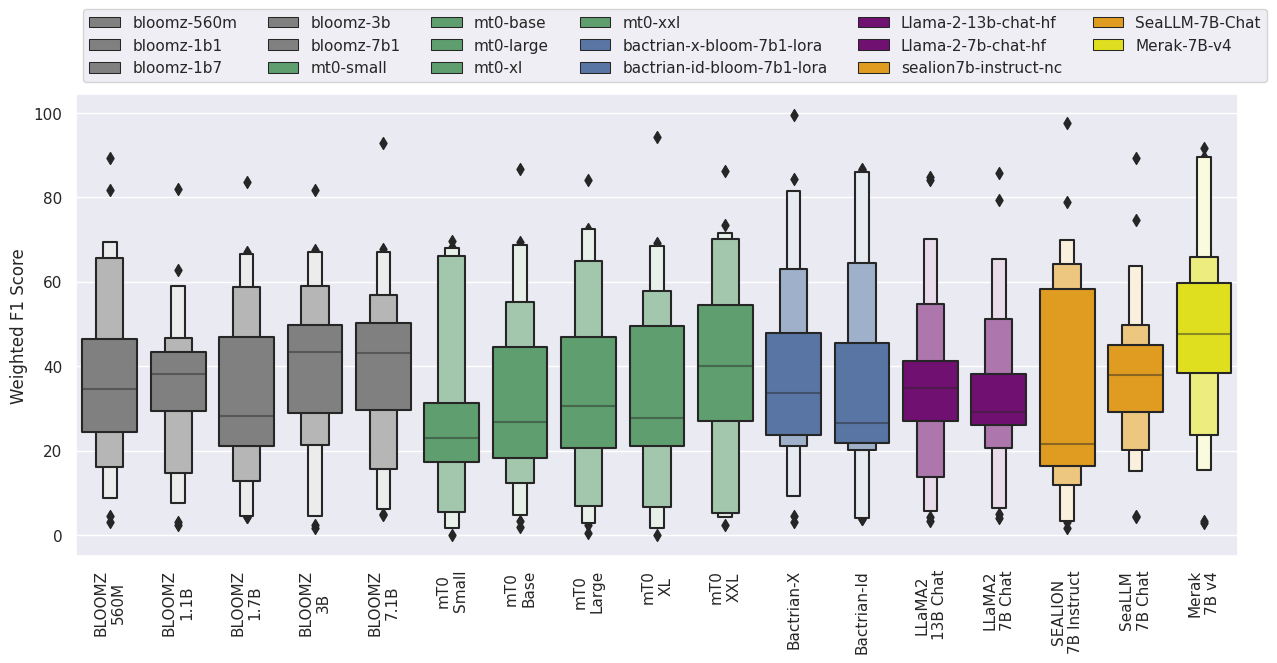

In [357]:
sns.set(rc={'figure.figsize':(15,6)})


pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf.sort_values('model_id')
sns.boxenplot(data=pdf, x='model_name', y='weighted_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score_baseline.pdf', bbox_inches='tight')
plt.show()

In [356]:
sns.set(rc={'figure.figsize':(15,6)})


pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
sns.boxenplot(data=pdf, x='model_name', y='weighted_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score (ind)')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score_ind_baseline.pdf', bbox_inches='tight')
plt.show()

In [341]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[~pdf['model'].str.contains('cendol')]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
ax= sns.boxenplot(data=pdf, x='model_name', y='weighted_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score (eng)')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score_eng_baseline.pdf', bbox_inches='tight')
plt.show()

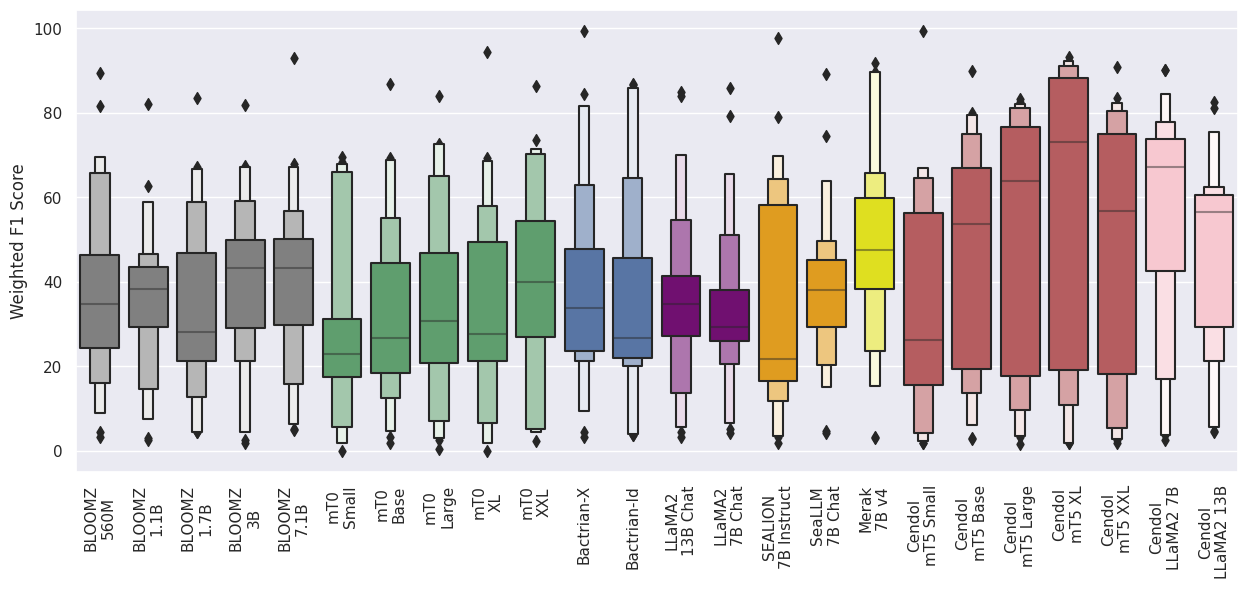

In [355]:
# With Cendol
sns.set(rc={'figure.figsize':(15,6)})


pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
# pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf.sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='weighted_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score.pdf', bbox_inches='tight')
plt.show()

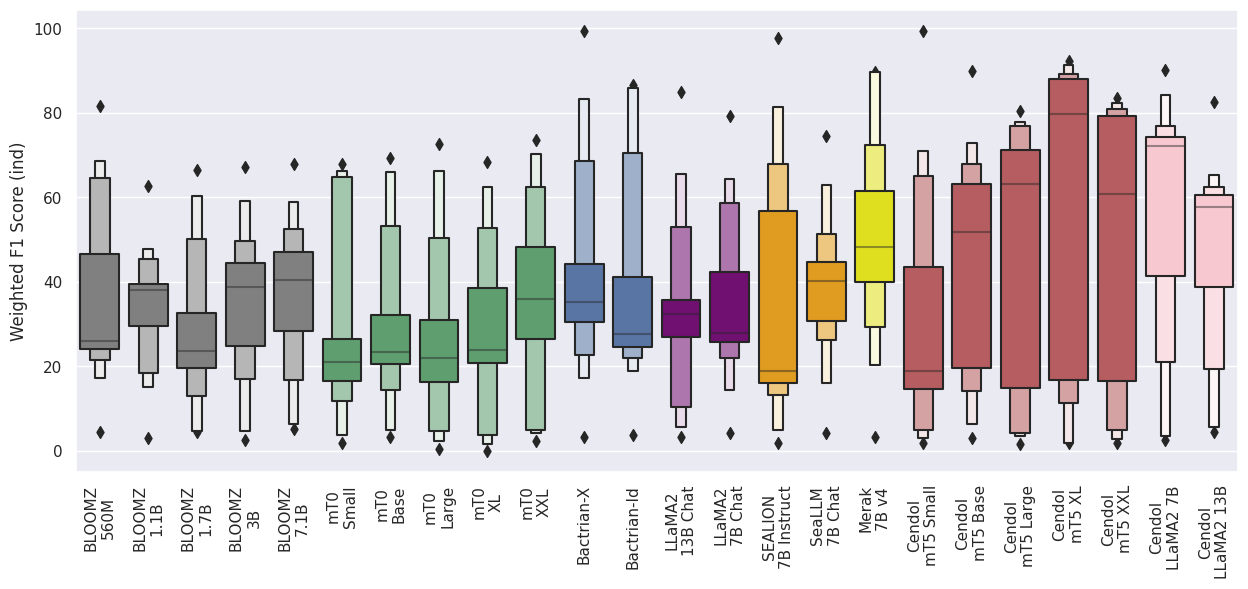

In [354]:
# With Cendol
sns.set(rc={'figure.figsize':(15,6)})


pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
# pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='weighted_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score (ind)')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

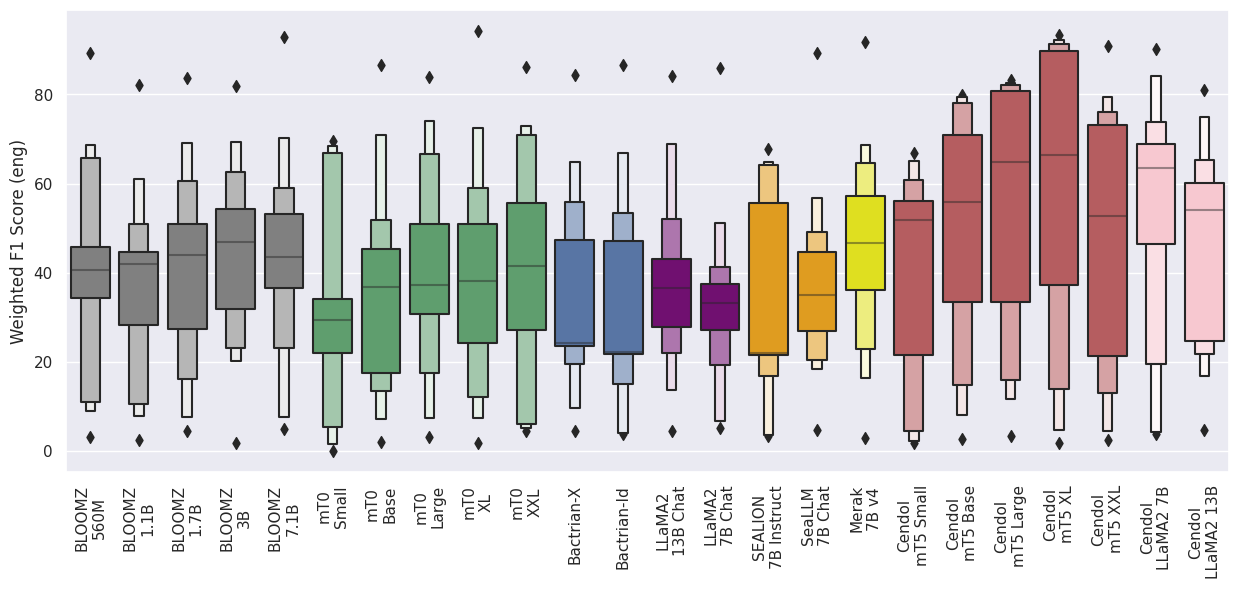

In [344]:
# With Cendol
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
# pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='weighted_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score (eng)')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score_eng.pdf', bbox_inches='tight')
plt.show()

# Other Metrics

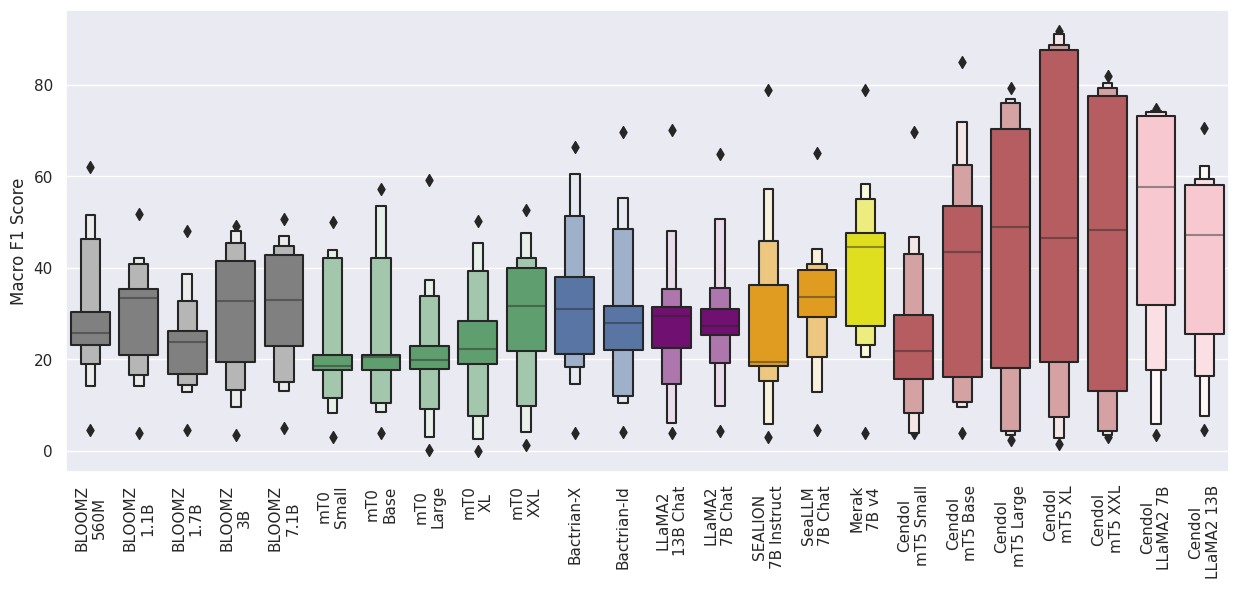

In [345]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='macro_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Macro F1 Score')
plt.xlabel(None)
plt.savefig('./figures/macro_f1_score.pdf', bbox_inches='tight')
plt.show()

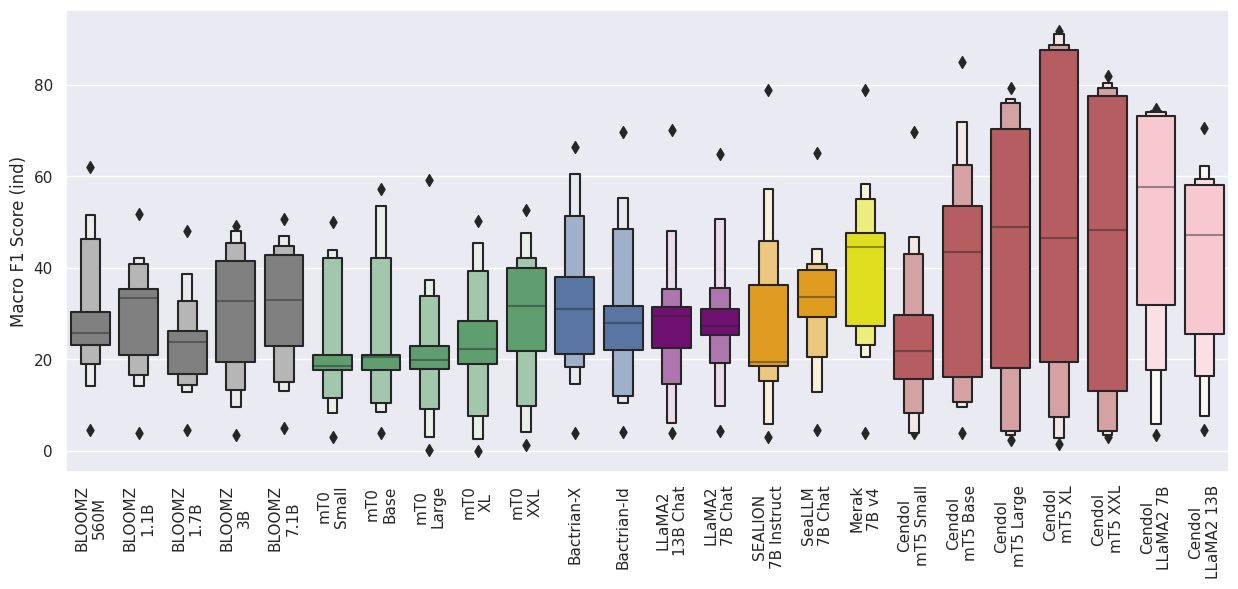

In [346]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='macro_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Macro F1 Score (ind)')
plt.xlabel(None)
plt.savefig('./figures/macro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

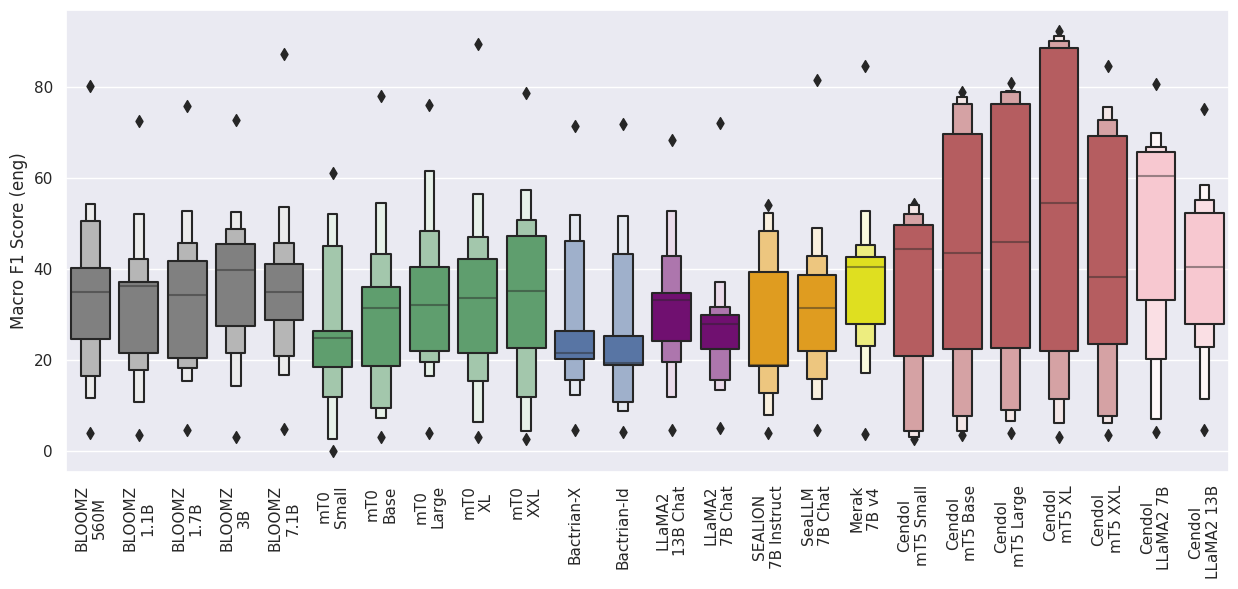

In [347]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='macro_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Macro F1 Score (eng)')
plt.xlabel(None)
plt.savefig('./figures/macro_f1_score_eng.pdf', bbox_inches='tight')
plt.show()

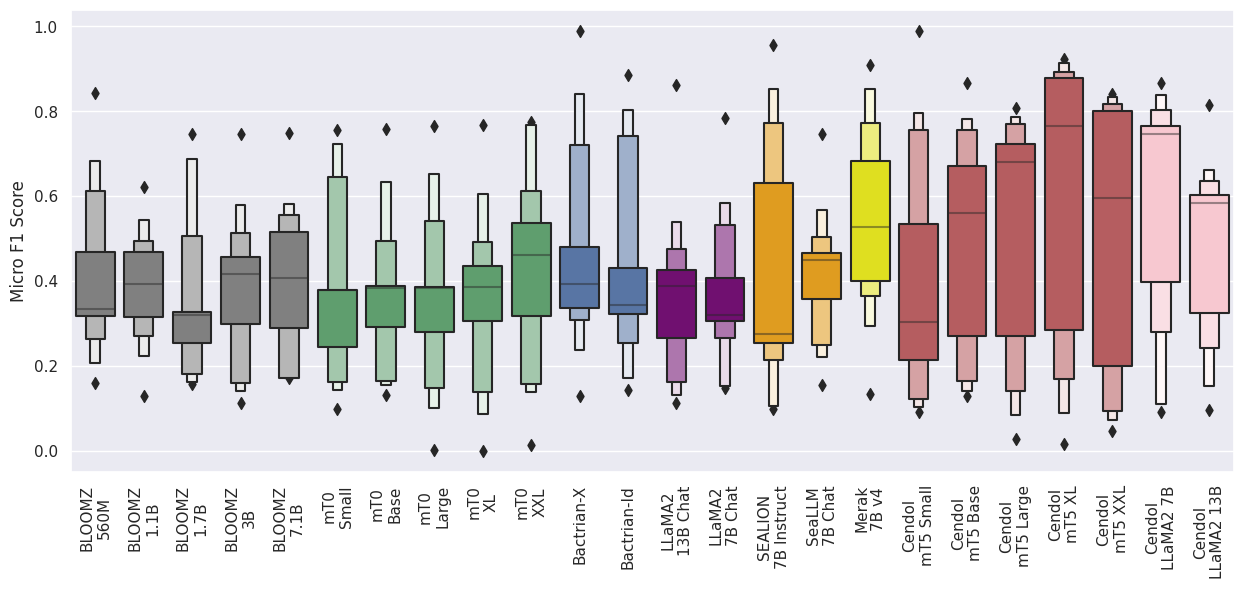

In [348]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='micro_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Micro F1 Score')
plt.xlabel(None)
plt.savefig('./figures/micro_f1_score.pdf', bbox_inches='tight')
plt.show()

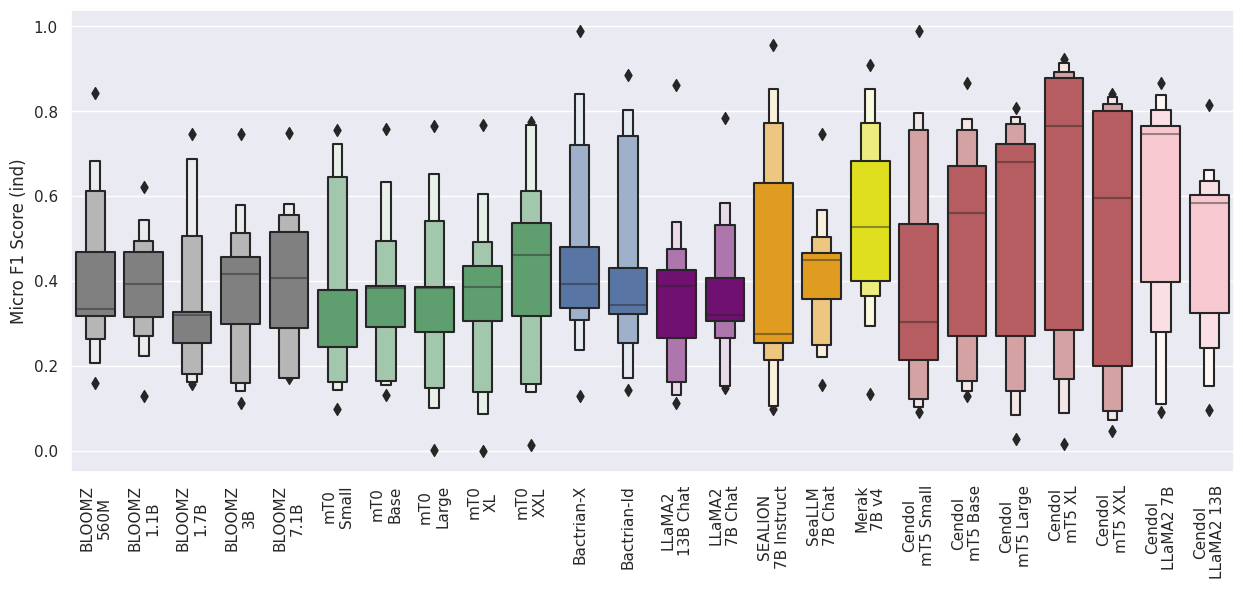

In [349]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='micro_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Micro F1 Score (ind)')
plt.xlabel(None)
plt.savefig('./figures/micro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

In [350]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='micro_f1_score', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Micro F1 Score (eng)')
plt.xlabel(None)
plt.savefig('./figures/micro_f1_score_eng.pdf', bbox_inches='tight')
plt.show()

In [351]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='accuracy', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Accuracy Score')
plt.xlabel(None)
plt.savefig('./figures/accuracy.pdf', bbox_inches='tight')
plt.show()

In [352]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='accuracy', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Accuracy Score (ind)')
plt.xlabel(None)
plt.savefig('./figures/accuracy_ind.pdf', bbox_inches='tight')
plt.show()

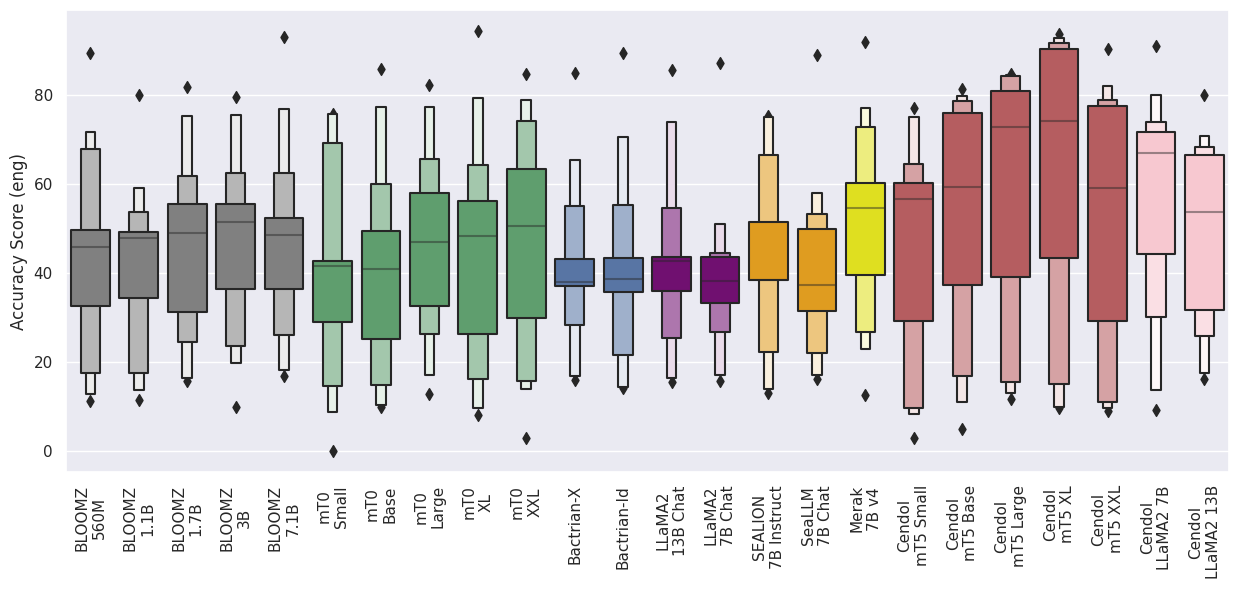

In [353]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','micro_f1_score','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='accuracy', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('Accuracy Score (eng)')
plt.xlabel(None)
plt.savefig('./figures/accuracy_eng.pdf', bbox_inches='tight')
plt.show()

# Other Test

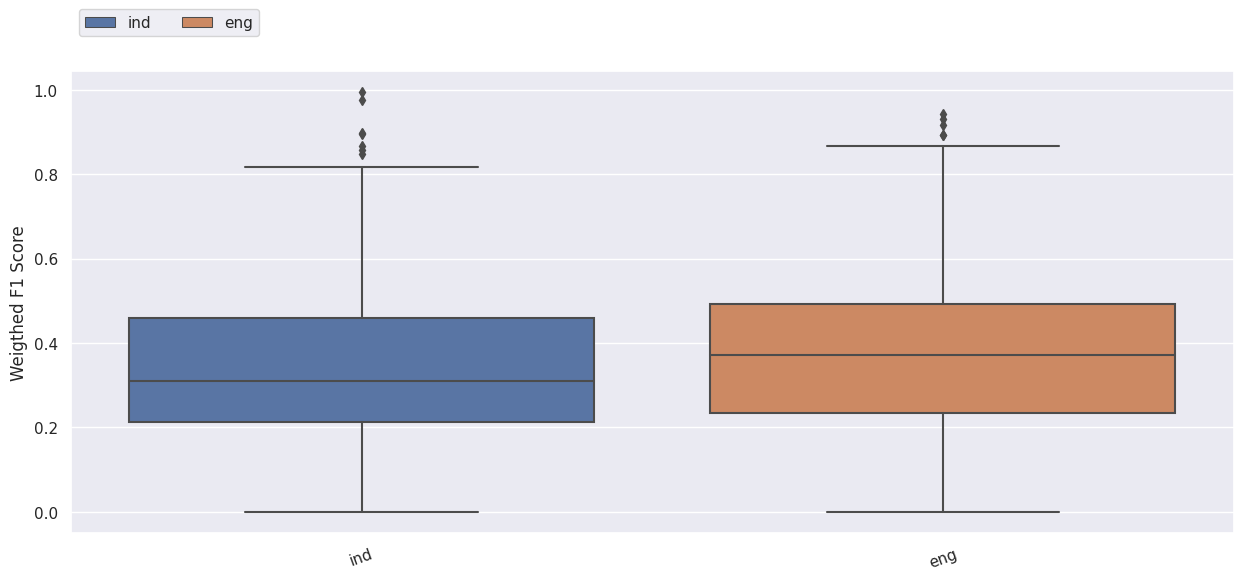

In [166]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxplot(pdf.sort_values('model_id'), x='lang', y='weighted_f1_score', hue='lang', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Weigthed F1 Score')
plt.xlabel(None)
plt.savefig('./figures/weighted_f1_score_lang.pdf', bbox_inches='tight')
plt.show()

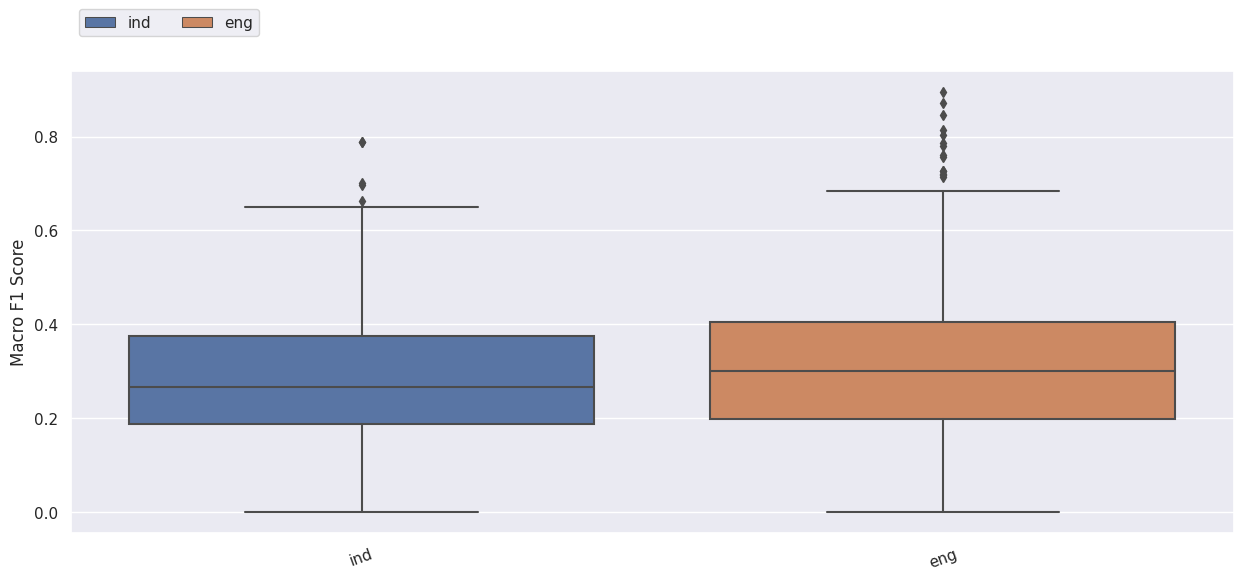

In [167]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxplot(pdf.sort_values('model_id'), x='lang', y='macro_f1_score', hue='lang', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Macro F1 Score')
plt.xlabel(None)
plt.savefig('./figures/macro_f1_score_lang.pdf', bbox_inches='tight')
plt.show()

In [168]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxplot(pdf.sort_values('model_id'), x='lang', y='accuracy', hue='lang', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Accuracy')
plt.xlabel(None)
plt.savefig('./figures/accuracy_lang.pdf', bbox_inches='tight')
plt.show()

### mT5 Based

In [180]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('mt'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxenplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=20)
plt.ylim(-0.01,1.0)
plt.ylabel('Weighted F1 Score (ind)')
plt.xlabel(None)
# plt.savefig('./figures/weighted_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

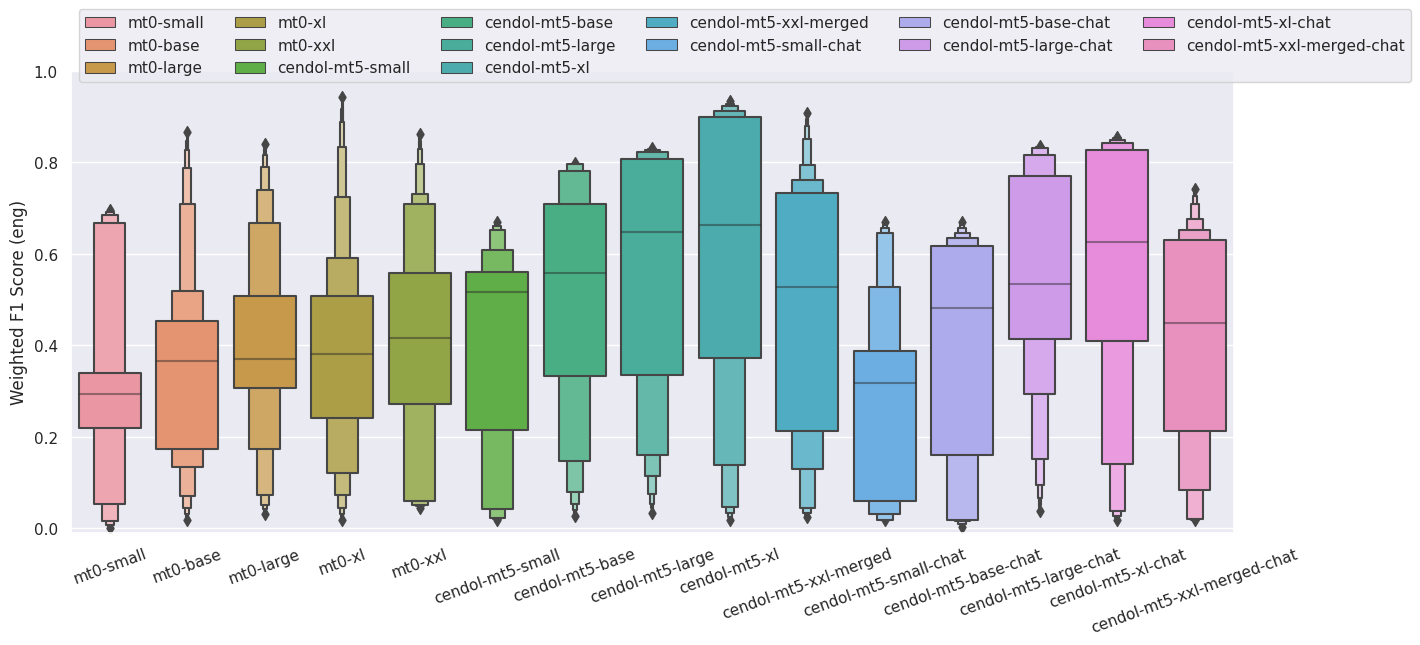

In [91]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('mt'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxenplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Weighted F1 Score (eng)')
plt.xlabel(None)
plt.ylim(-0.01,1.0)
# plt.savefig('./figures/weighted_f1_score_eng.pdf', bbox_inches='tight')
plt.show()

### LLaMA Based

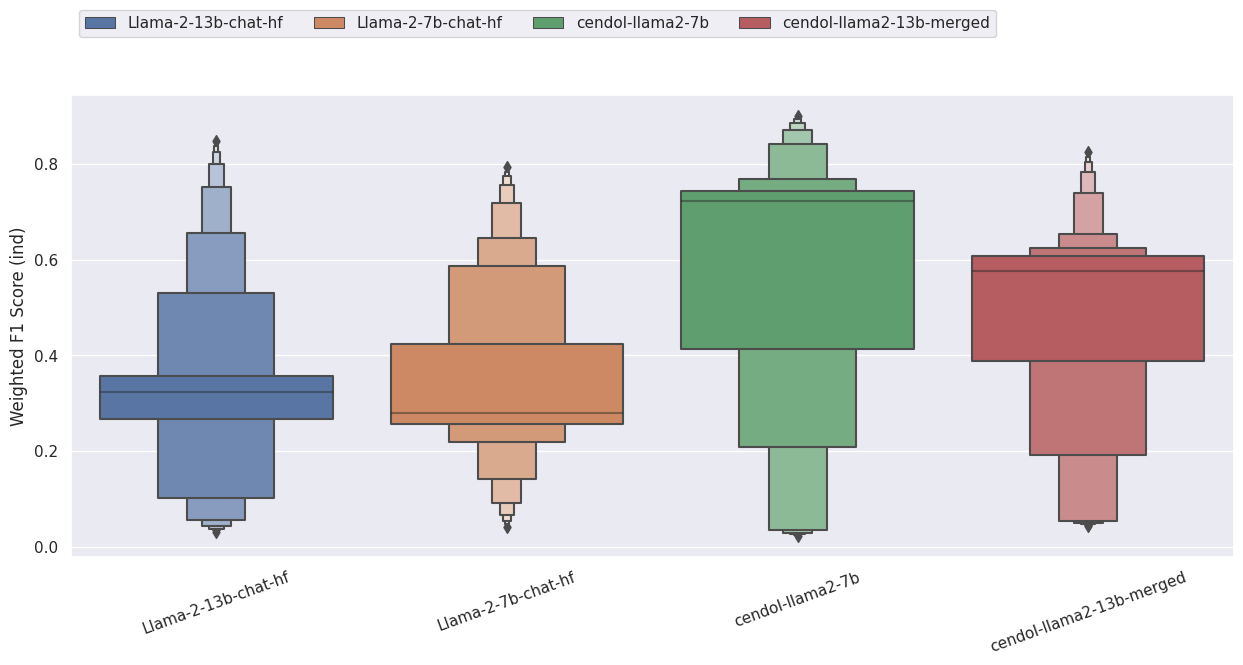

In [100]:
sns.set(rc={'figure.figsize':(15,6)})


pdf = df.groupby(['dataset', 'model', 'lang'])[[ 'accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('lama'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxenplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Weighted F1 Score (ind)')
plt.xlabel(None)
# plt.savefig('./figures/macro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

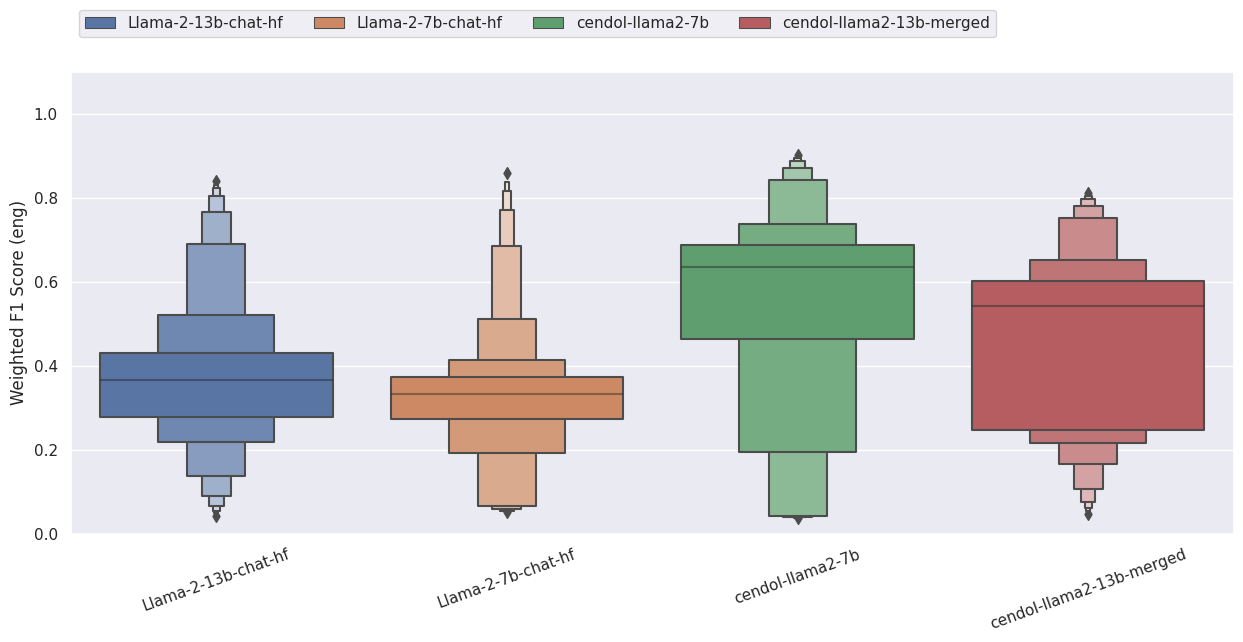

In [101]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('lama'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxenplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Weighted F1 Score (eng)')
plt.xlabel(None)

plt.ylim(0.0,1.1)
# plt.savefig('./figures/macro_f1_score_eng.pdf', bbox_inches='tight')
plt.show()

### Cendol Only

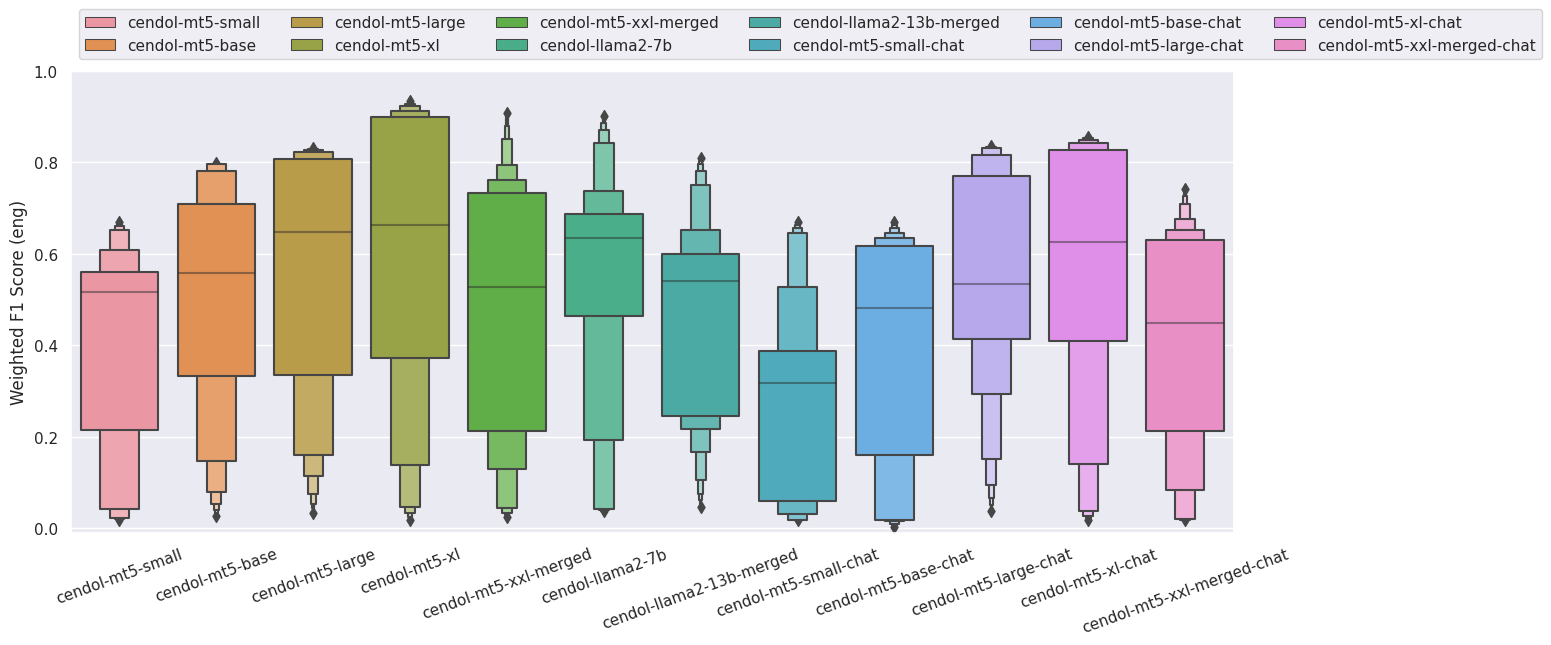

In [181]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[['accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('cendol'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxenplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Weighted F1 Score (eng)')
plt.xlabel(None)
plt.ylim(-0.01,1.0)
# plt.savefig('./figures/weighted_f1_score_eng.pdf', bbox_inches='tight')
plt.show()

### Show Eng & Ind

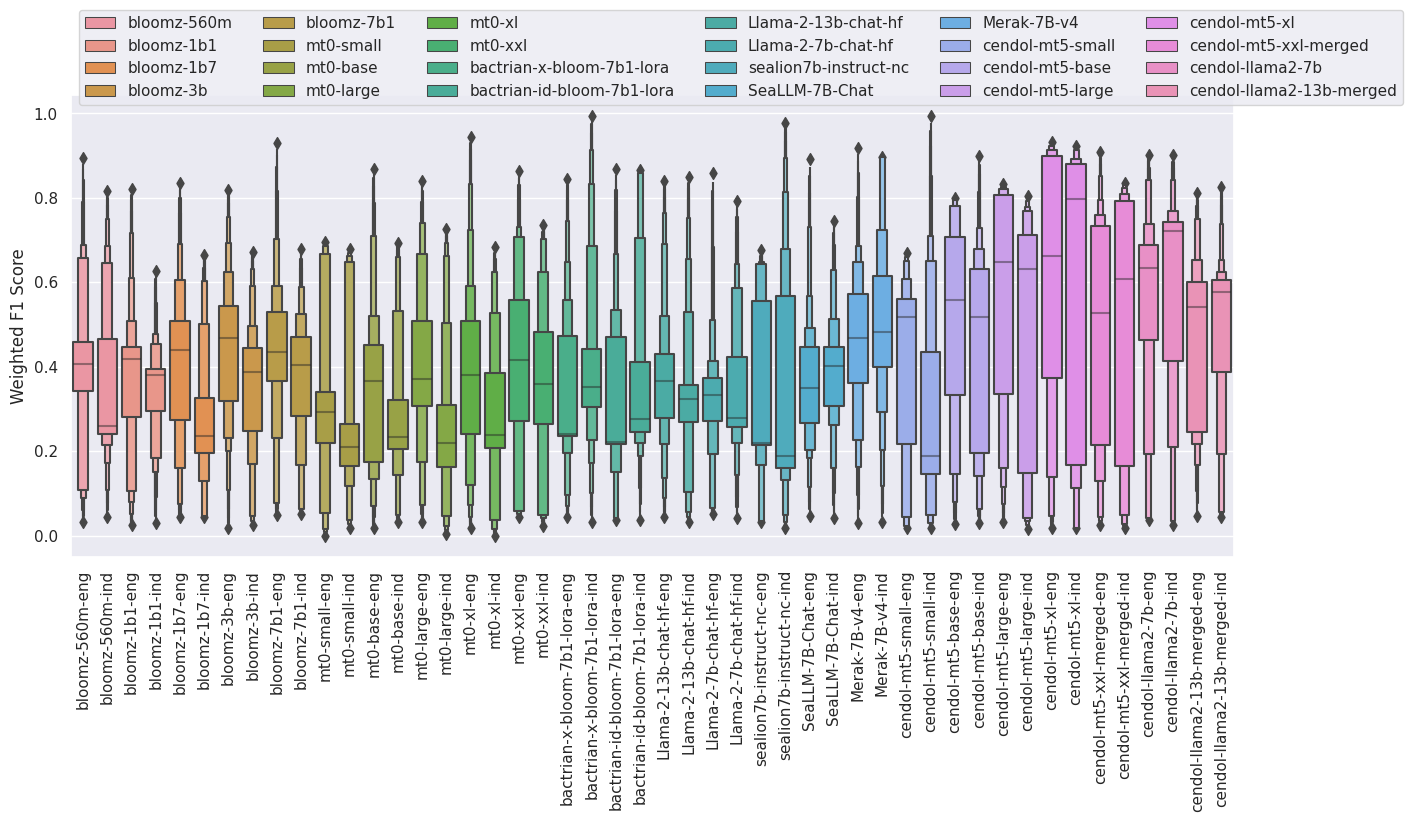

In [184]:
# Cendol Only
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[[ 'accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
# pdf = pdf.loc[pdf['model'].str.contains('cendol'),:]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['lang_model'] = pdf.apply(lambda x: x['model'] + '-' + x['lang'], axis='columns')
sns.boxenplot(pdf.sort_values(['model_id','lang']), x='lang_model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score')
plt.xlabel(None)
# plt.savefig('./figures/macro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

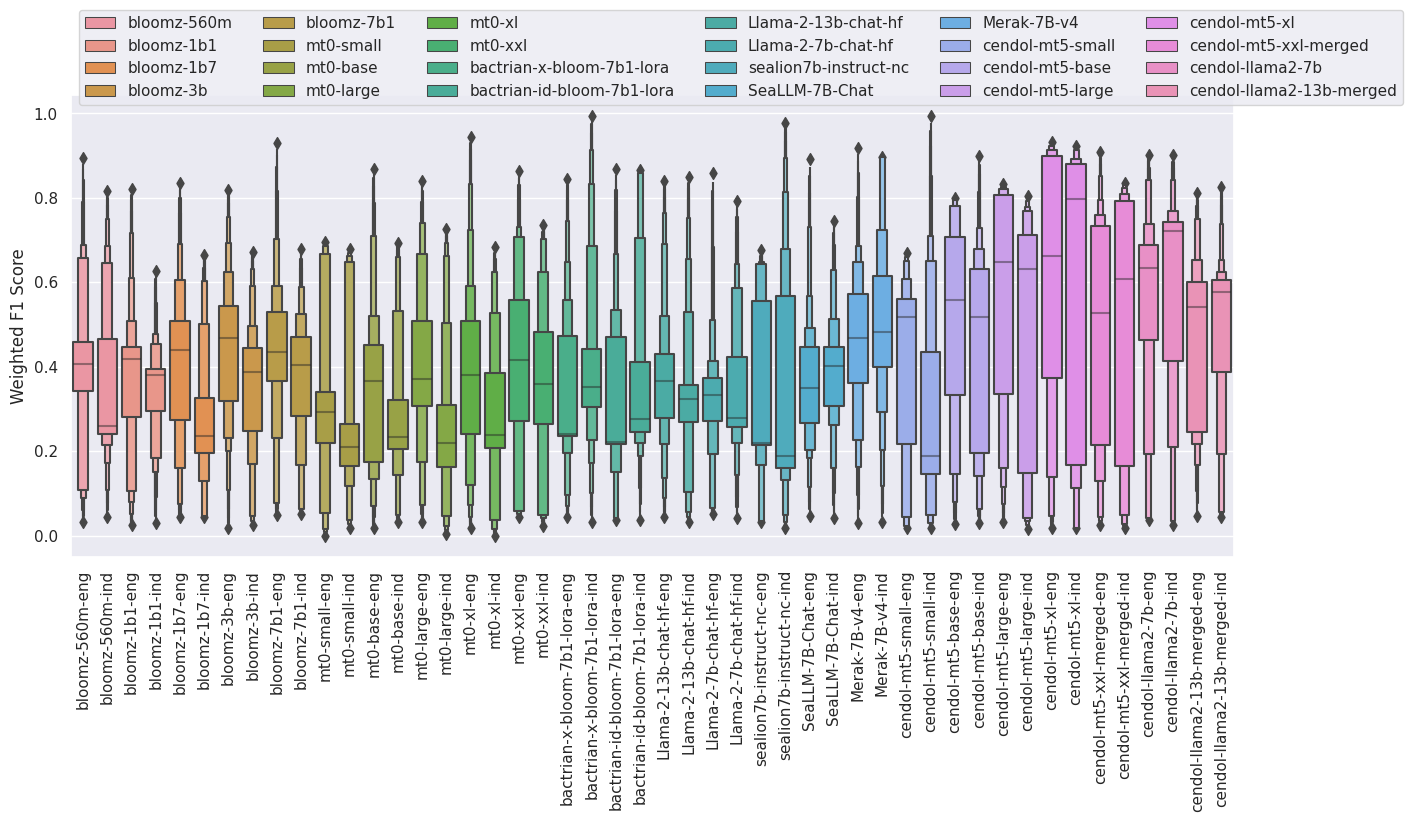

In [185]:
# Non Cendol
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[[ 'accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
# pdf = pdf.loc[~pdf['model'].str.contains('cendol'),:]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['lang_model'] = pdf.apply(lambda x: x['model'] + '-' + x['lang'], axis='columns')
sns.boxenplot(pdf.sort_values(['model_id','lang']), x='lang_model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score')
plt.xlabel(None)
# plt.savefig('./figures/macro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

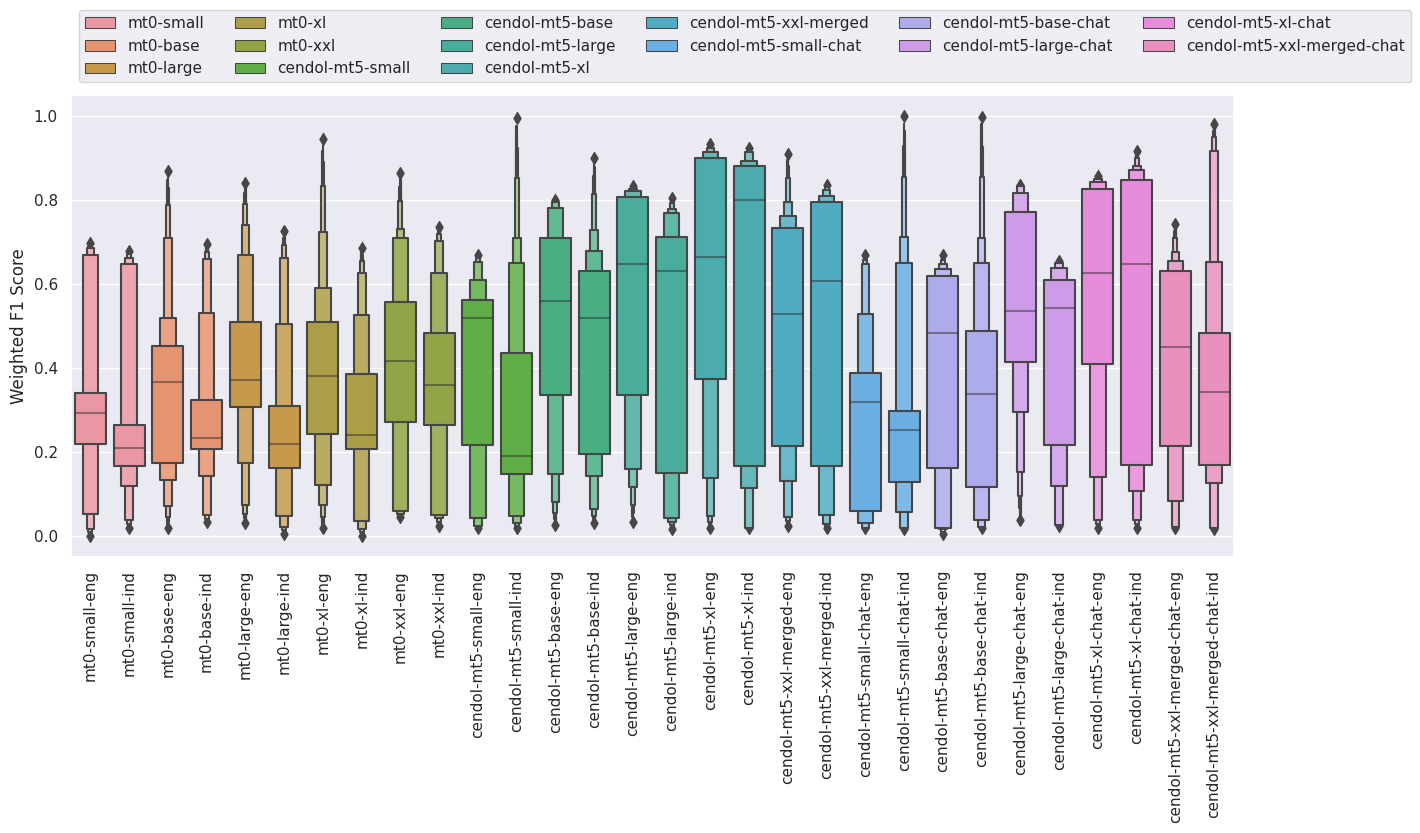

In [187]:
# mT5
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[[ 'accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('mt'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['lang_model'] = pdf.apply(lambda x: x['model'] + '-' + x['lang'], axis='columns')
sns.boxenplot(pdf.sort_values(['model_id', 'lang']), x='lang_model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=90)
plt.ylabel('Weighted F1 Score')
plt.xlabel(None)
# plt.savefig('./figures/macro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

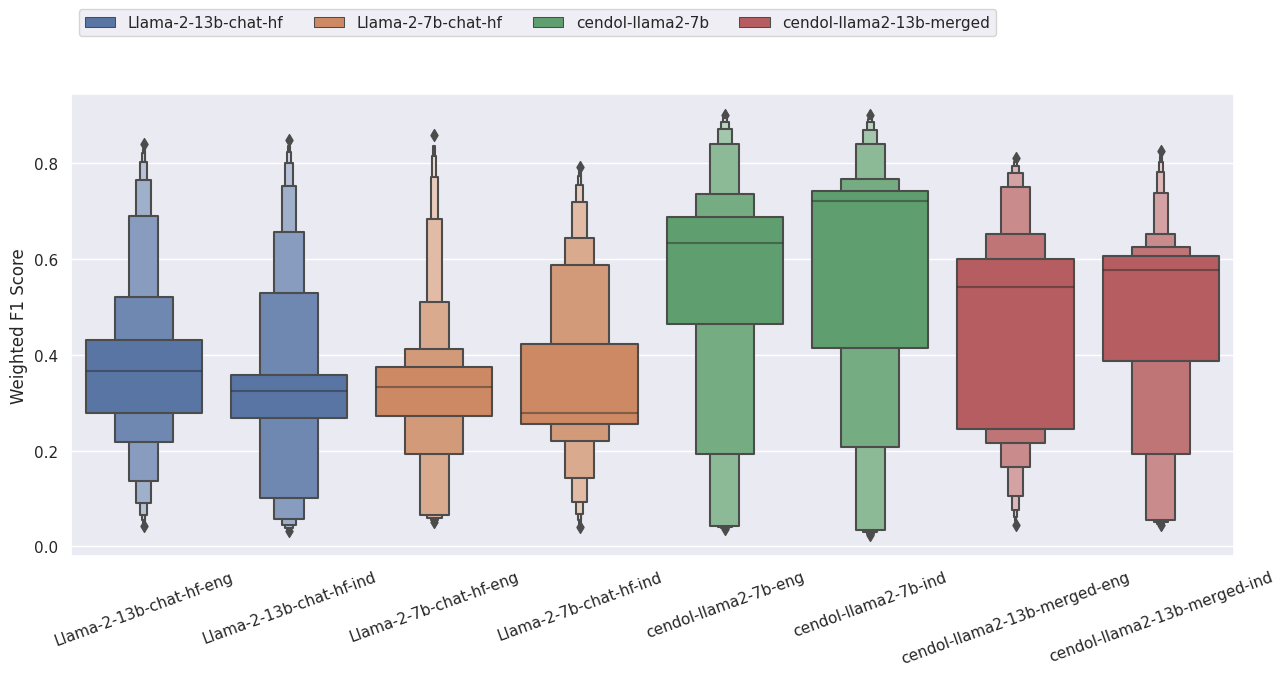

In [186]:
# LLaMA
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.groupby(['dataset', 'model', 'lang'])[[ 'accuracy','macro_f1_score','weighted_f1_score']].mean().reset_index()
pdf = pdf.loc[pdf['model'].str.contains('lama'),:]
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['lang_model'] = pdf.apply(lambda x: x['model'] + '-' + x['lang'], axis='columns')
sns.boxenplot(pdf.sort_values(['model_id', 'lang']), x='lang_model', y=metric, hue='model', k_depth=7, dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('Weighted F1 Score')
plt.xlabel(None)
# plt.savefig('./figures/macro_f1_score_ind.pdf', bbox_inches='tight')
plt.show()

## Insights
- Effect of Instruction-Tuned on Indonesian
  - Significantly increase the performance on target languages (Full: ~10-20%, LoRA: ~5%)
  - Reduce the gap between HRL (English) & target language instruction => Generalization of prompt language?
- LoRA
  - Performance: LoRA on largest model not as good as full fine-tuning w/ smaller models. i.e., mt5-large & mt5-xl is better than mt5-xxl-lora
  - Efficiency: While the performance of mt5-large is only as slightly higher as mt5-xxl-lora, the throughput is 3x higher

# Save

In [66]:
df.to_csv('raw_result_nlu.csv', index=False)

In [67]:
df.groupby(['model', 'lang']).size().sort_values().reset_index()

model lang   0
0          Llama-2-13b-chat-hf  eng  75
1              cendol-mt5-base  ind  75
2             cendol-mt5-large  eng  75
3             cendol-mt5-large  ind  75
4             cendol-mt5-small  eng  75
5             cendol-mt5-small  ind  75
6                cendol-mt5-xl  eng  75
7                cendol-mt5-xl  ind  75
8        cendol-mt5-xxl-merged  eng  75
9        cendol-mt5-xxl-merged  ind  75
10                    mt0-base  eng  75
11                    mt0-base  ind  75
12                   mt0-large  eng  75
13                   mt0-large  ind  75
14                   mt0-small  eng  75
15                   mt0-small  ind  75
16                      mt0-xl  eng  75
17                      mt0-xl  ind  75
18                     mt0-xxl  eng  75
19                     mt0-xxl  ind  75
20             cendol-mt5-base  eng  75
21            cendol-llama2-7b  ind  75
22            cendol-llama2-7b  eng  75
23    cendol-llama2-13b-merged  ind  75
24         Llama-2-13b-chat-hf  ind  75
25          Llama-2-7b-chat-hf  eng  75
26          Llama-2-7b-chat-hf  ind  75
27                 Merak-7B-v4  eng  75
28                 Merak-7B-v4  ind  75
29  bactrian-id-bloom-7b1-lora  eng  75
30  bactrian-id-bloom-7b1-lora  ind  75
31   bactrian-x-bloom-7b1-lora  eng  75
32   bactrian-x-bloom-7b1-lora  ind  75
33                   sealion7b  eng  75
34                  bloomz-1b1  eng  75
35                  bloomz-1b7  eng  75
36                  bloomz-1b7  ind  75
37                   bloomz-3b  eng  75
38                   bloomz-3b  ind  75
39                 bloomz-560m  eng  75
40                 bloomz-560m  ind  75
41                  bloomz-7b1  eng  75
42                  bloomz-7b1  ind  75
43    cendol-llama2-13b-merged  eng  75
44                  bloomz-1b1  ind  75
45                   sealion7b  ind  75

# NLG

In [359]:
dfs = []
for path in glob.glob('metrics_nlg/*.csv'):
    model = path[:-4].split('_')[-1]
    if model == 'sealion7b':
        continue
    lang = path.split('results')[1].split('_')[1]
    df = pd.read_csv(path).set_index('index')
    df['BLEU'] = df['BLEU'].astype(float)
    df['SacreBLEU'] = df['SacreBLEU'].astype(float)
    df['chrF++'] = df['chrF++'].astype(float)
    df['ROUGE1'] = df['ROUGE1'].astype(float)
    df['ROUGE2'] = df['ROUGE2'].astype(float)
    df['ROUGEL'] = df['ROUGEL'].astype(float)
    df['ROUGELsum'] = df['ROUGELsum'].astype(float)
    df['model'] = model
    df['lang'] = lang
    dfs.append(df)
df = pd.concat(dfs)
df = df[df['dataset'] != 'xpersona_id_nusantara_t2t']

In [360]:
df[df['model'].str.contains('cendol')].to_csv('combine_nlg.csv')

In [361]:
df[(df['lang'] == 'ind')].groupby(['model','lang'])[['SacreBLEU','ROUGE1', 'ROUGE2', 'ROUGEL','chrF++']].mean().sort_values(['model','SacreBLEU'])

SacreBLEU     ROUGE1     ROUGE2     ROUGEL  \
model                      lang                                               
Llama-2-13b-chat-hf        ind    3.491855  17.408252   6.397490  16.070944   
Llama-2-7b-chat-hf         ind    2.855489  14.940335   5.464974  13.984853   
Merak-7B-v4                ind    2.754213  15.345768   4.218233  13.590762   
SeaLLM-7B-Chat             ind    3.222374  18.395567   5.903341  16.256607   
bactrian-id-bloom-7b1-lora ind    2.512010  14.968249   4.749311  13.523019   
bactrian-x-bloom-7b1-lora  ind    1.043114   9.106870   2.397877   8.151451   
bloomz-1b1                 ind    3.687485  14.283274   4.299907  13.150481   
bloomz-1b7                 ind    4.278578  13.089773   4.583733  12.221784   
bloomz-3b                  ind    5.823659  17.926600   6.533066  16.704965   
bloomz-560m                ind    3.817210  12.809180   4.154453  12.048300   
bloomz-7b1                 ind    7.019796  20.110615   7.826098  18.743148   
cendol-llama2-13b-merged   ind   33.848020  51.848793  36.149264  50.726769   
cendol-llama2-7b           ind   41.485630  56.776622  43.432977  55.691589   
cendol-mt5-base            ind   26.064014  45.195532  27.959840  44.133234   
cendol-mt5-base-chat       ind    3.342103  18.173853   5.991404  15.831450   
cendol-mt5-large           ind   32.914996  51.288489  35.150283  50.242232   
cendol-mt5-large-chat      ind    5.324437  22.863889   8.768221  20.539115   
cendol-mt5-small           ind   17.465740  36.581614  19.169956  35.672951   
cendol-mt5-small-chat      ind    2.621467  15.056782   4.382298  13.195753   
cendol-mt5-xl              ind   42.862172  58.613304  45.405643  57.604644   
cendol-mt5-xl-chat         ind    5.148553  23.448195   9.056197  21.049853   
cendol-mt5-xxl-merged      ind   26.810610  47.335898  29.200322  46.271183   
cendol-mt5-xxl-merged-chat ind    3.455932  18.237078   5.913518  15.635186   
mt0-base                   ind    6.380389  21.025819   7.390862  19.798904   
mt0-large                  ind    7.448810  22.132994   8.529370  20.826814   
mt0-small                  ind    3.991534  15.234907   4.783852  14.329162   
mt0-xl                     ind   10.819873  27.613863  12.363183  26.313243   
mt0-xxl                    ind   13.608290  31.086820  15.723019  29.855405   
sealion7b-instruct-nc      ind    1.398274  11.569597   3.024426   9.813064   

                                    chrF++  
model                      lang             
Llama-2-13b-chat-hf        ind   31.748986  
Llama-2-7b-chat-hf         ind   29.982405  
Merak-7B-v4                ind   28.776106  
SeaLLM-7B-Chat             ind   32.251991  
bactrian-id-bloom-7b1-lora ind   26.941885  
bactrian-x-bloom-7b1-lora  ind   22.771275  
bloomz-1b1                 ind   23.435741  
bloomz-1b7                 ind   21.904319  
bloomz-3b                  ind   26.202500  
bloomz-560m                ind   21.579013  
bloomz-7b1                 ind   28.005185  
cendol-llama2-13b-merged   ind   55.954605  
cendol-llama2-7b           ind   61.542530  
cendol-mt5-base            ind   50.058641  
cendol-mt5-base-chat       ind   31.335495  
cendol-mt5-large           ind   55.248486  
cendol-mt5-large-chat      ind   34.161873  
cendol-mt5-small           ind   42.701919  
cendol-mt5-small-chat      ind   28.164359  
cendol-mt5-xl              ind   61.800679  
cendol-mt5-xl-chat         ind   34.002448  
cendol-mt5-xxl-merged      ind   52.078779  
cendol-mt5-xxl-merged-chat ind   31.945479  
mt0-base                   ind   29.626949  
mt0-large                  ind   29.573464  
mt0-small                  ind   24.716269  
mt0-xl                     ind   34.950330  
mt0-xxl                    ind   37.417450  
sealion7b-instruct-nc      ind   28.049274

In [362]:
df[(df['lang'] == 'eng')].groupby(['model','lang'])[['SacreBLEU','ROUGE1', 'ROUGE2', 'ROUGEL','chrF++']].mean().sort_values(['model','SacreBLEU'])

SacreBLEU     ROUGE1     ROUGE2     ROUGEL  \
model                      lang                                               
Llama-2-13b-chat-hf        eng    1.831031   9.172567   3.244235   8.687830   
Llama-2-7b-chat-hf         eng    1.911577  10.150166   3.578563   9.771467   
Merak-7B-v4                eng    3.145723  16.098953   4.697591  14.358742   
SeaLLM-7B-Chat             eng    2.546884  15.001918   4.757914  13.497175   
bactrian-id-bloom-7b1-lora eng    1.828950  10.260876   3.261739   9.552469   
bactrian-x-bloom-7b1-lora  eng    0.814679   6.063270   1.687972   5.596476   
bloomz-1b1                 eng    4.145185  15.850170   4.941602  14.548177   
bloomz-1b7                 eng    6.753898  19.686551   7.411420  18.570691   
bloomz-3b                  eng    7.022884  19.892330   7.662295  18.663869   
bloomz-560m                eng    5.236633  17.227899   5.807683  15.980704   
bloomz-7b1                 eng    7.337698  20.879080   8.201724  19.575324   
cendol-llama2-13b-merged   eng   30.814338  49.052079  33.171221  47.988251   
cendol-llama2-7b           eng   39.823541  54.559973  41.137542  53.523433   
cendol-mt5-base            eng   18.788503  35.548259  20.652812  34.648398   
cendol-mt5-base-chat       eng    2.906849  15.449068   5.143778  13.610528   
cendol-mt5-large           eng   24.289738  42.243787  26.410745  41.353208   
cendol-mt5-large-chat      eng    4.723945  18.926289   7.420639  17.247245   
cendol-mt5-small           eng   14.443251  33.172070  16.551661  32.233677   
cendol-mt5-small-chat      eng    2.305568  13.314783   3.975997  11.793616   
cendol-mt5-xl              eng   30.468621  45.853537  32.091071  44.980825   
cendol-mt5-xl-chat         eng    5.134734  20.775002   8.188965  18.810456   
cendol-mt5-xxl-merged      eng   23.492000  43.360847  25.623388  42.363628   
cendol-mt5-xxl-merged-chat eng    3.618428  18.189917   6.274731  15.776048   
mt0-base                   eng    5.804004  19.034728   6.602516  17.902344   
mt0-large                  eng    7.224409  21.611695   8.232855  20.354043   
mt0-small                  eng    4.609297  16.922002   5.378454  15.991750   
mt0-xl                     eng    9.809450  25.627877  10.949825  24.302098   
mt0-xxl                    eng   13.544988  30.190565  15.489147  29.006695   
sealion7b-instruct-nc      eng    1.216592  10.375897   2.620203   8.808657   

                                    chrF++  
model                      lang             
Llama-2-13b-chat-hf        eng   24.844185  
Llama-2-7b-chat-hf         eng   25.572762  
Merak-7B-v4                eng   28.885337  
SeaLLM-7B-Chat             eng   29.637783  
bactrian-id-bloom-7b1-lora eng   22.647129  
bactrian-x-bloom-7b1-lora  eng   20.157295  
bloomz-1b1                 eng   24.360352  
bloomz-1b7                 eng   28.959221  
bloomz-3b                  eng   28.368598  
bloomz-560m                eng   26.629871  
bloomz-7b1                 eng   29.341248  
cendol-llama2-13b-merged   eng   53.668486  
cendol-llama2-7b           eng   59.444945  
cendol-mt5-base            eng   44.209466  
cendol-mt5-base-chat       eng   29.071150  
cendol-mt5-large           eng   49.571138  
cendol-mt5-large-chat      eng   30.928147  
cendol-mt5-small           eng   42.161427  
cendol-mt5-small-chat      eng   26.513939  
cendol-mt5-xl              eng   52.492621  
cendol-mt5-xl-chat         eng   32.196230  
cendol-mt5-xxl-merged      eng   49.294264  
cendol-mt5-xxl-merged-chat eng   31.845507  
mt0-base                   eng   27.484624  
mt0-large                  eng   28.899203  
mt0-small                  eng   26.126227  
mt0-xl                     eng   33.599806  
mt0-xxl                    eng   36.788167  
sealion7b-instruct-nc      eng   26.961606

# STIF

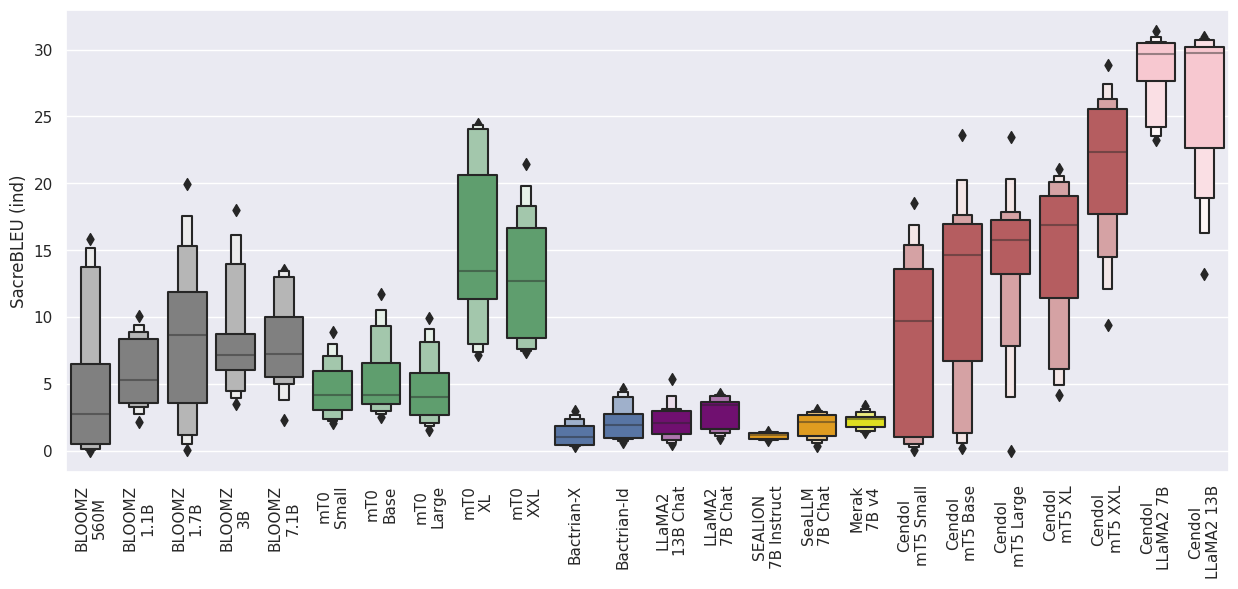

In [363]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'stif_indonesia_nusantara_t2t']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf.sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (ind)')
plt.xlabel(None)
plt.savefig('./figures/bleu_stif.pdf', bbox_inches='tight')
plt.show()

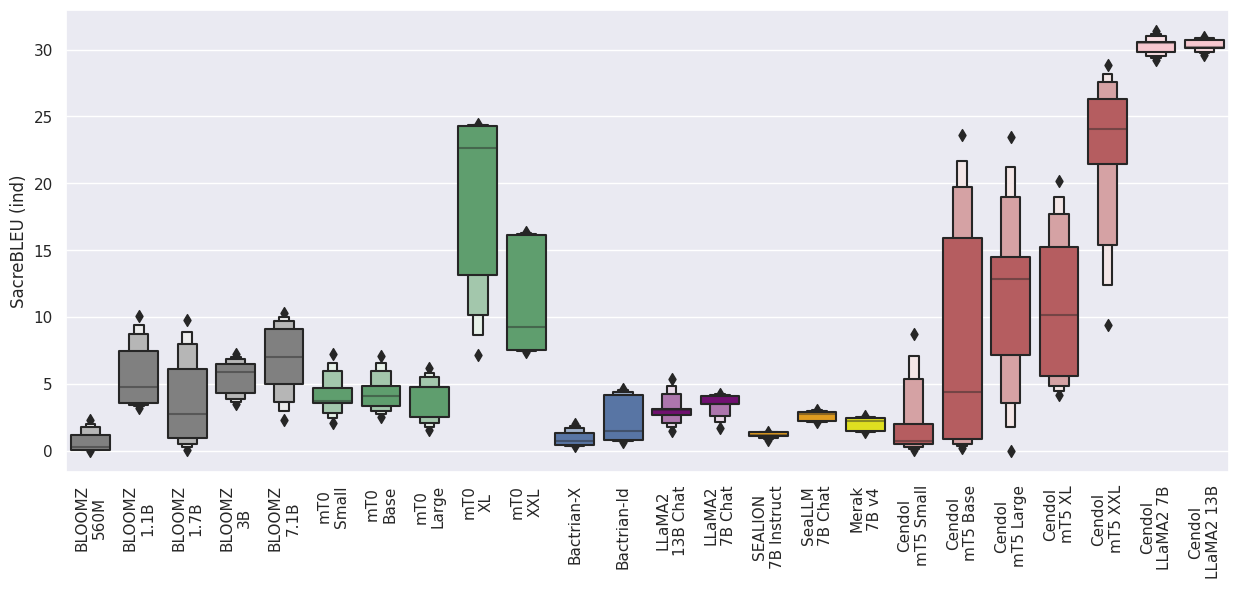

In [364]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'stif_indonesia_nusantara_t2t']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (ind)')
plt.xlabel(None)
plt.savefig('./figures/bleu_stif_ind.pdf', bbox_inches='tight')
plt.show()

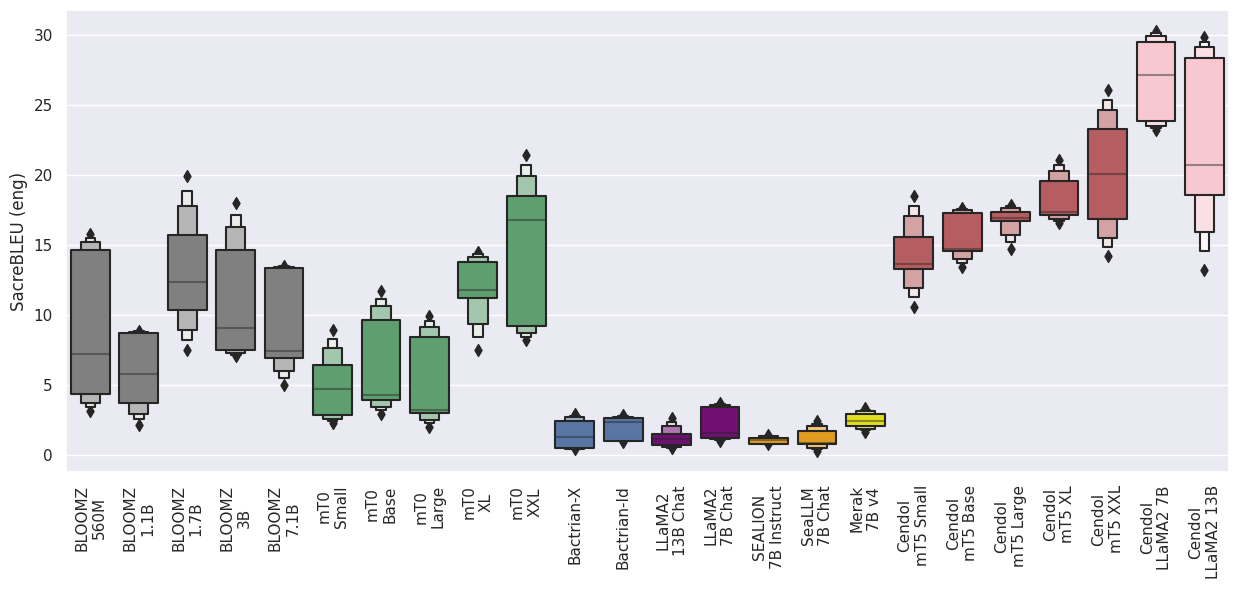

In [365]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'stif_indonesia_nusantara_t2t']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (eng)')
plt.xlabel(None)
plt.savefig('./figures/bleu_stif_eng.pdf', bbox_inches='tight')
plt.show()

# MT Directional

### To Ind

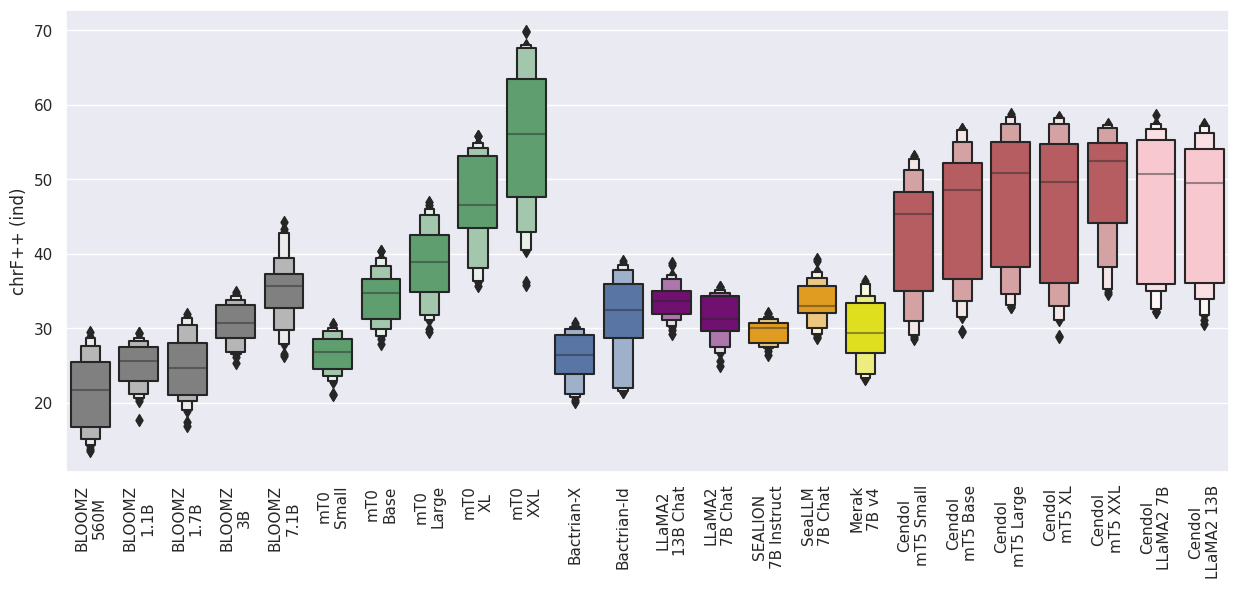

In [366]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.endswith('ind_Latn')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='chrF++', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('chrF++ (ind)')
plt.xlabel(None)
plt.savefig('./figures/chrf_mt2ind_ind.pdf', bbox_inches='tight')
plt.show()

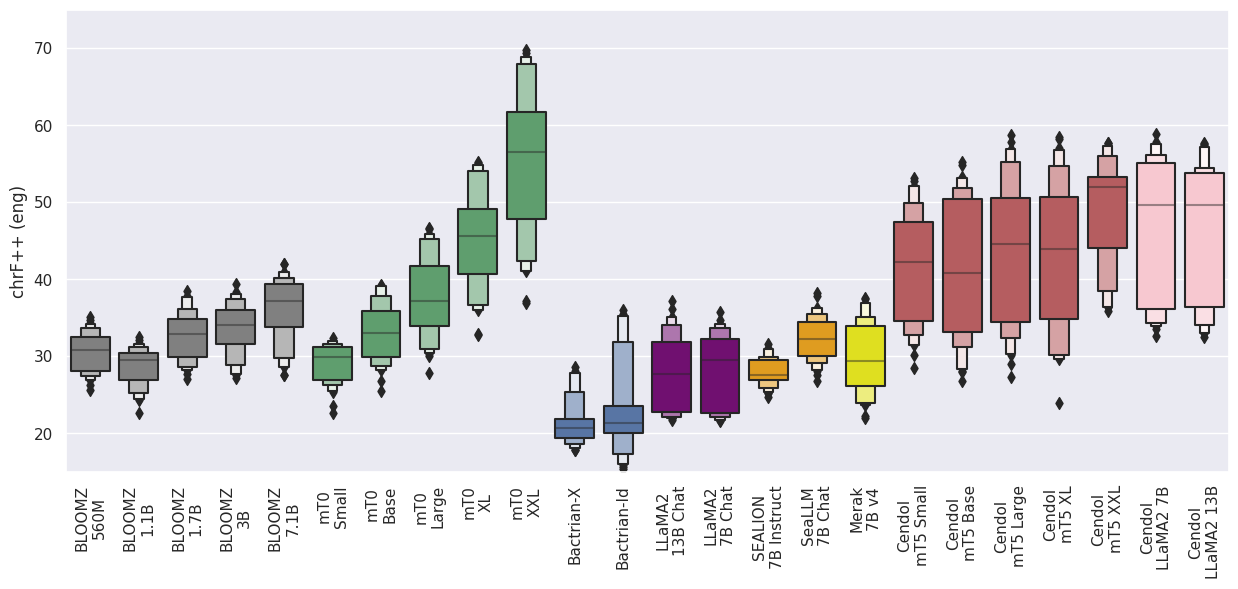

In [367]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.endswith('ind_Latn')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='chrF++', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylim(15,75)
plt.ylabel('chrF++ (eng)')
plt.xlabel(None)
plt.savefig('./figures/chrf_mt2ind_eng.pdf', bbox_inches='tight')
plt.show()

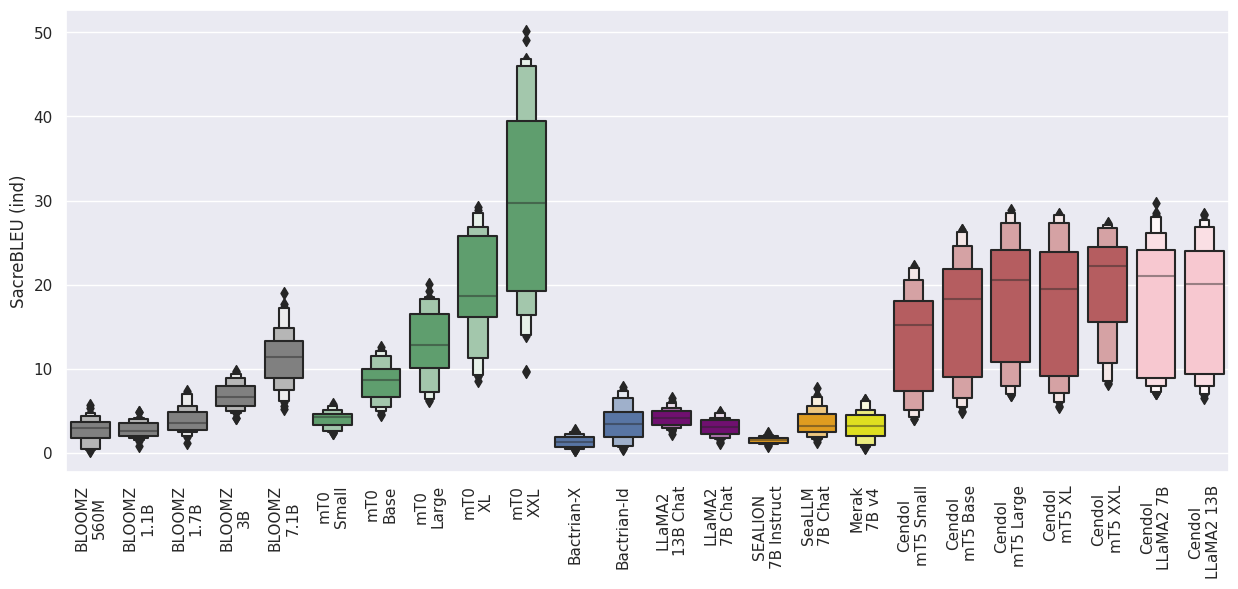

In [368]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.endswith('ind_Latn')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (ind)')
plt.xlabel(None)
plt.savefig('./figures/bleu_mt2ind_ind.pdf', bbox_inches='tight')
plt.show()

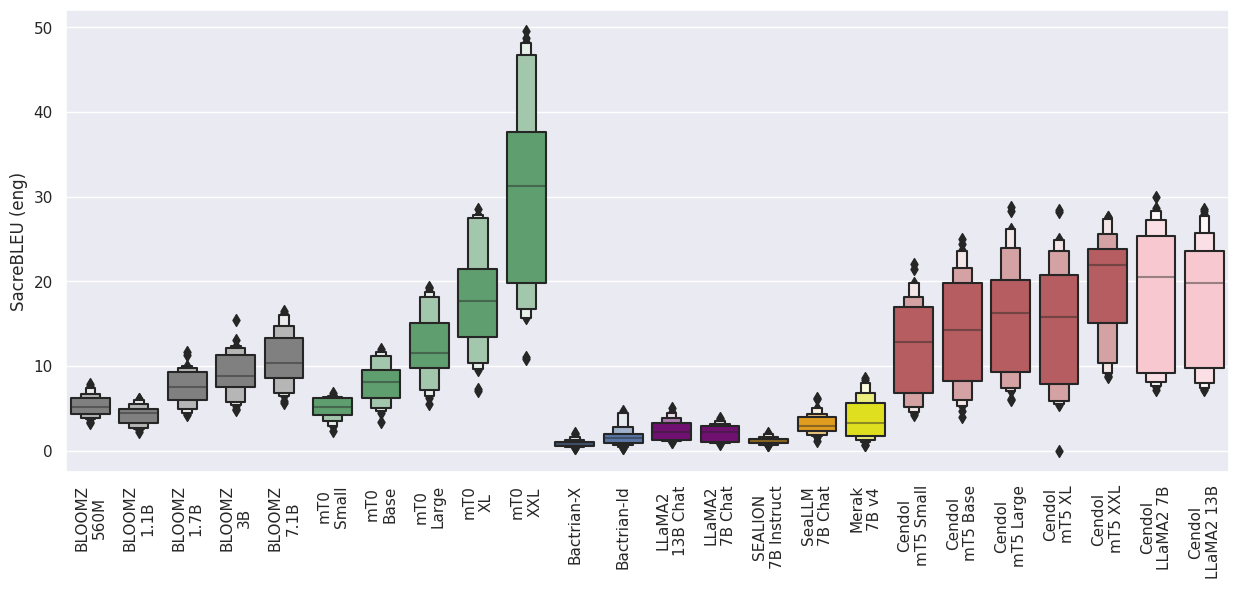

In [369]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.endswith('ind_Latn')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (eng)')
plt.xlabel(None)
plt.savefig('./figures/bleu_mt2ind_eng.pdf', bbox_inches='tight')
plt.show()

### From Ind

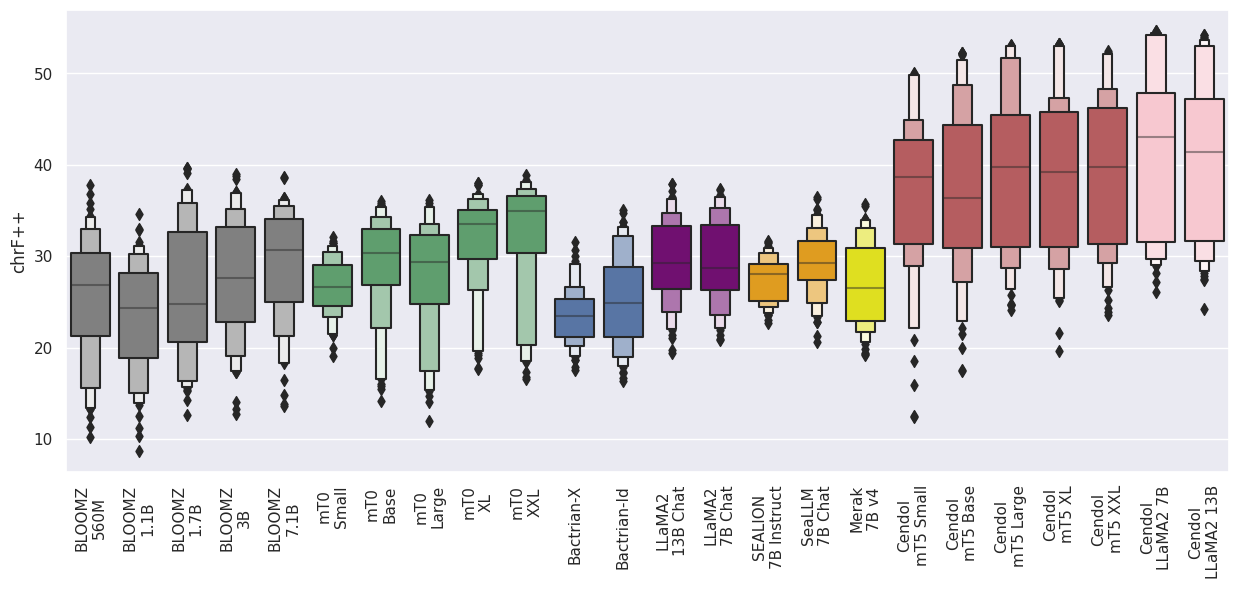

In [370]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.contains('-ind_Latn-')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf.sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='chrF++', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('chrF++')
plt.xlabel(None)
plt.savefig('./figures/chrf_mt2oth.pdf', bbox_inches='tight')
plt.show()

In [371]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.contains('-ind_Latn-')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='chrF++', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('chrF++ (ind)')
plt.xlabel(None)
plt.savefig('./figures/chrf_mt2oth_ind.pdf', bbox_inches='tight')
plt.show()

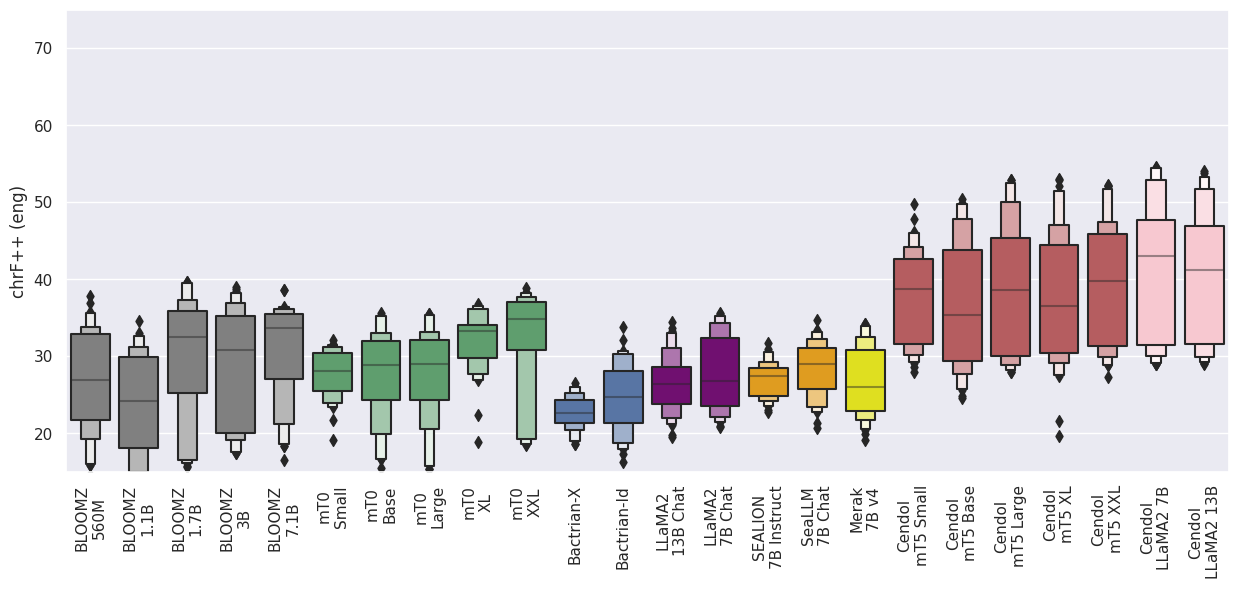

In [372]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.contains('-ind_Latn-')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='chrF++', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylim(15,75)
plt.ylabel('chrF++ (eng)')
plt.xlabel(None)
plt.savefig('./figures/chrf_mt2oth_eng.pdf', bbox_inches='tight')
plt.show()

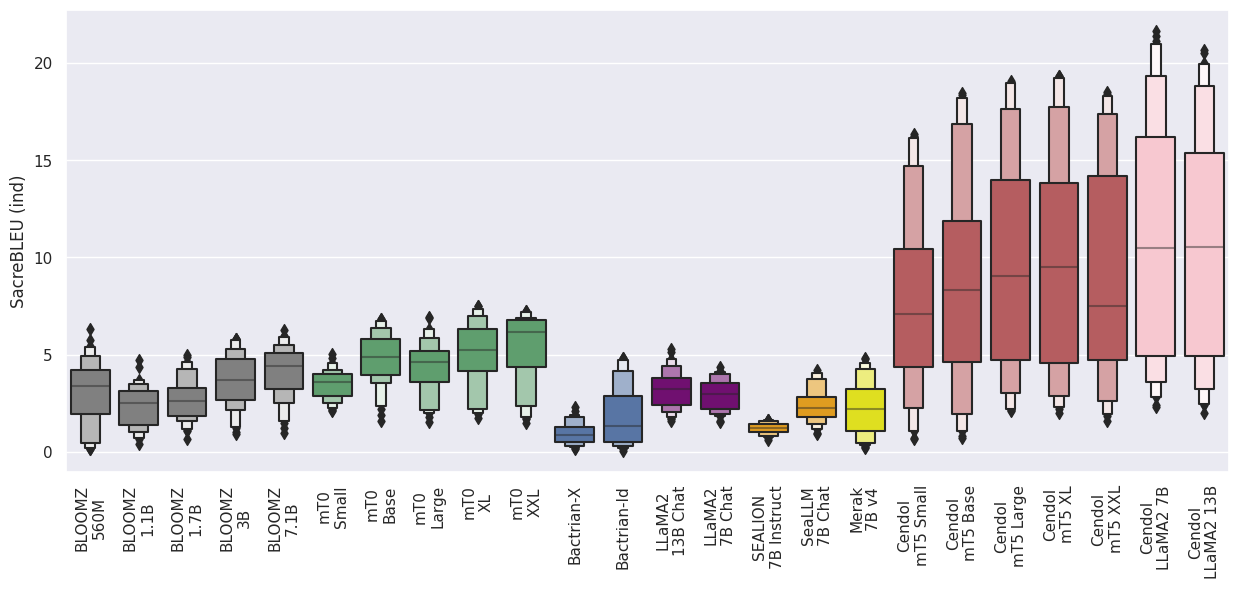

In [373]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.contains('-ind_Latn-')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (ind)')
plt.xlabel(None)
plt.savefig('./figures/bleu_mt2oth_ind.pdf', bbox_inches='tight')
plt.show()

In [374]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'].str.contains('-ind_Latn-')]
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
# sns.boxplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='macro_f1_score', hue='model', dodge=False)
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (eng)')
plt.xlabel(None)
plt.savefig('./figures/bleu_mt2oth_eng.pdf', bbox_inches='tight')
plt.show()

## TydiQA

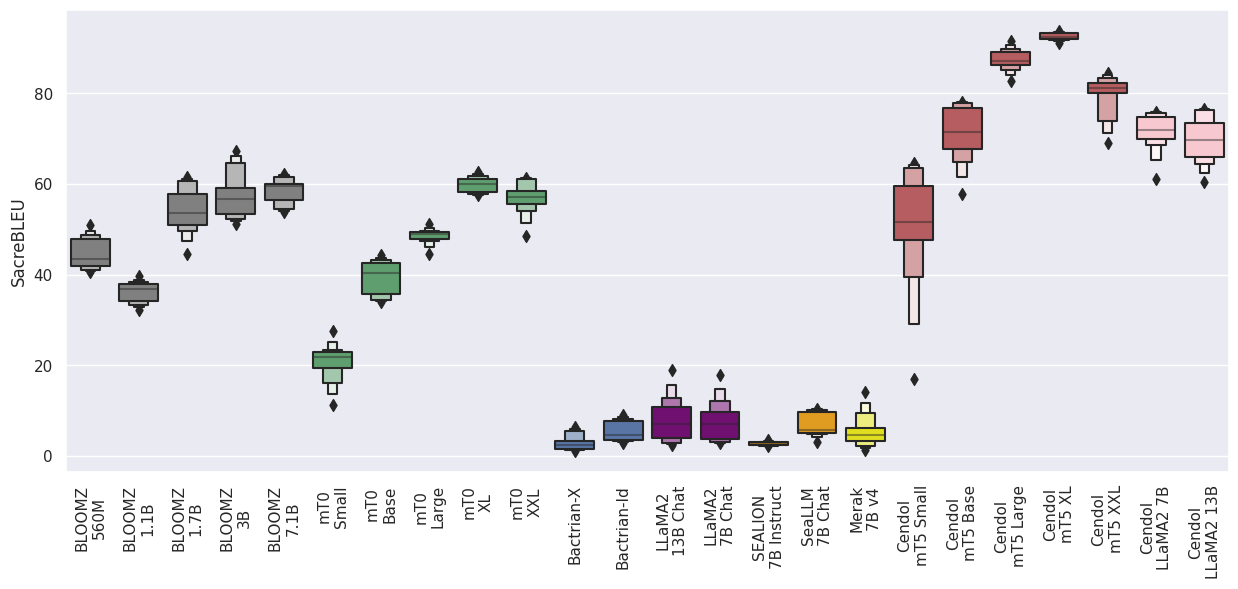

In [375]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'tydiqa_id_nusantara_qa']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf.sort_values('model_id')
          
ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU')
plt.xlabel(None)
plt.savefig('sacrebleu_qa.pdf', bbox_inches='tight')
plt.show()

In [376]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'tydiqa_id_nusantara_qa']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')
          
ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (ind)')
plt.xlabel(None)
plt.savefig('sacrebleu_qa_ind.pdf', bbox_inches='tight')
plt.show()

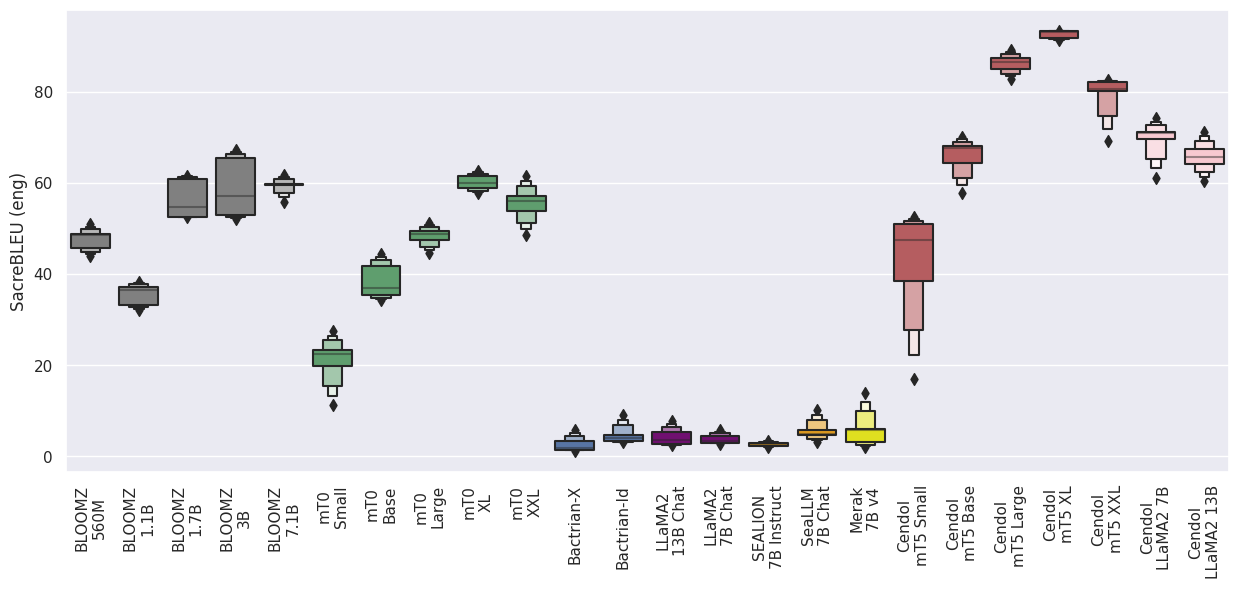

In [379]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'tydiqa_id_nusantara_qa']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')
          
ax = sns.boxenplot(pdf, x='model_name', y='SacreBLEU', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())

# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('SacreBLEU (eng)')
plt.xlabel(None)
plt.savefig('sacrebleu_qa_eng.pdf', bbox_inches='tight')
plt.show()

# Summarization

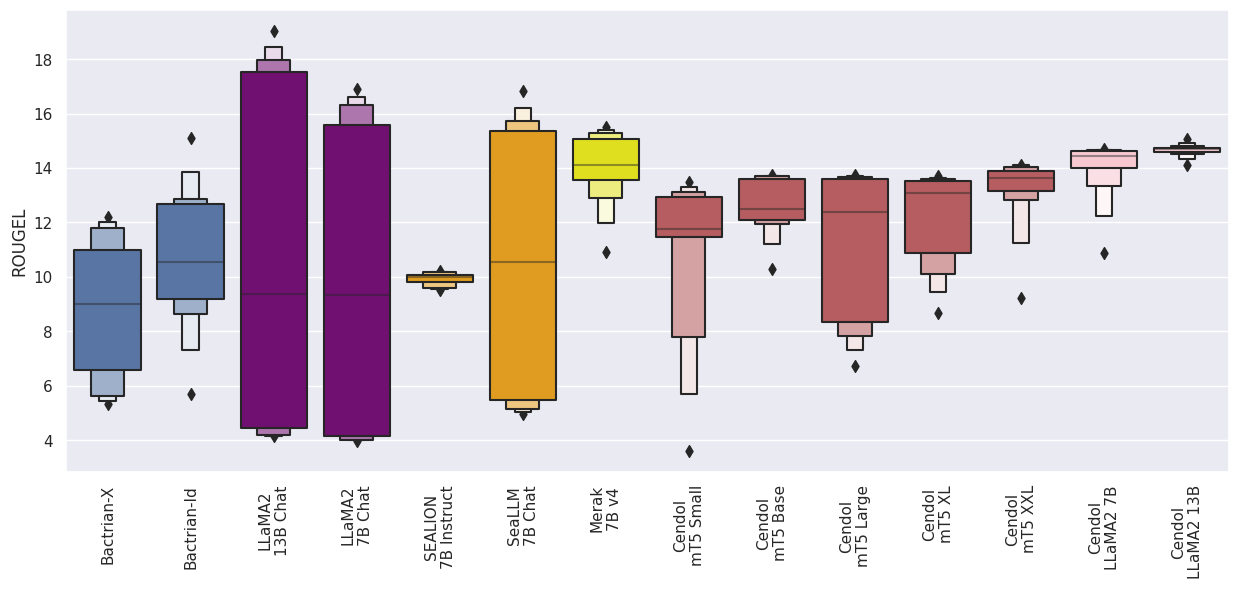

In [382]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'xl_sum_nusantara_t2t']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[(~pdf['model'].str.startswith('bloomz-')) & (~pdf['model'].str.startswith('mt0'))]
pdf = pdf.sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='ROUGEL', hue='model', k_depth=3, dodge=False, palette=list(model_to_color.values())[10:])
# sns.boxplot(pdf[(pdf['dataset'] == 'xl_sum_nusantara_t2t') & (pdf['lang'] == 'ind')].sort_values('model_id'), x='model', y='ROUGEL', hue='model', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('ROUGEL')
plt.xlabel(None)
plt.savefig('./figures/rougel_xlsum.pdf', bbox_inches='tight')
plt.show()

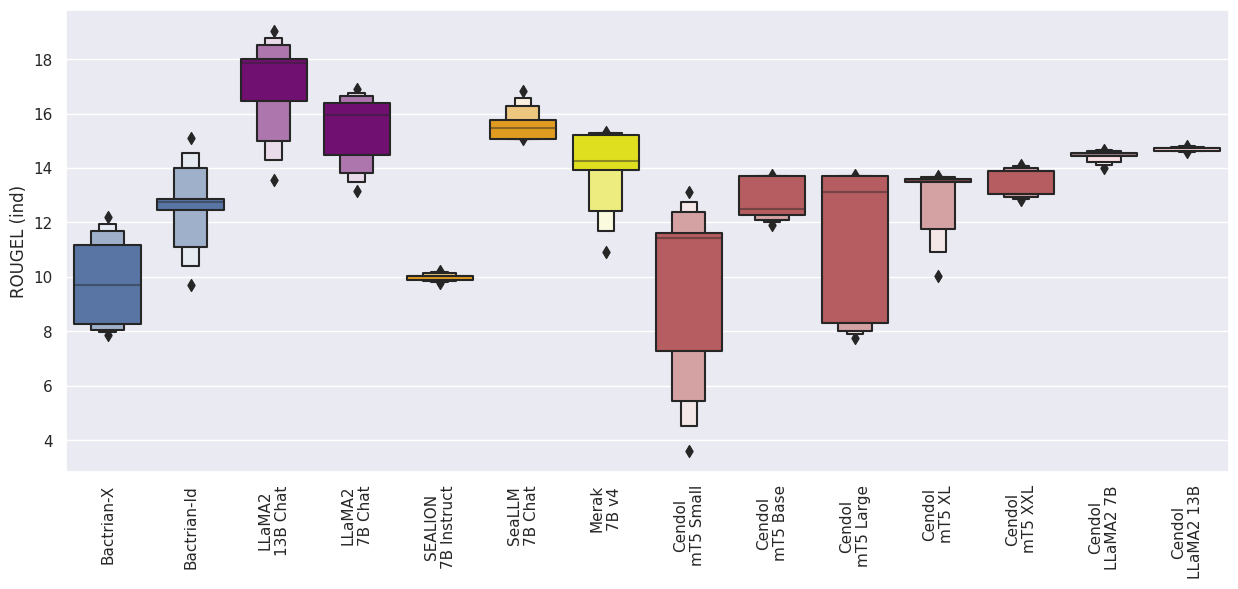

In [383]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'xl_sum_nusantara_t2t']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[(~pdf['model'].str.startswith('bloomz-')) & (~pdf['model'].str.startswith('mt0'))]
pdf = pdf[pdf['lang'] == 'ind'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='ROUGEL', hue='model', k_depth=3, dodge=False, palette=list(model_to_color.values())[10:])
# ax = sns.boxenplot(pdf, x='model_name', y='ROUGEL', hue='model', k_depth=3, dodge=False, palette=model_to_color.values())
# sns.boxplot(pdf[(pdf['dataset'] == 'xl_sum_nusantara_t2t') & (pdf['lang'] == 'ind')].sort_values('model_id'), x='model', y='ROUGEL', hue='model', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('ROUGEL (ind)')
plt.xlabel(None)
plt.savefig('./figures/rougel_xlsum_ind.pdf', bbox_inches='tight')
plt.show()

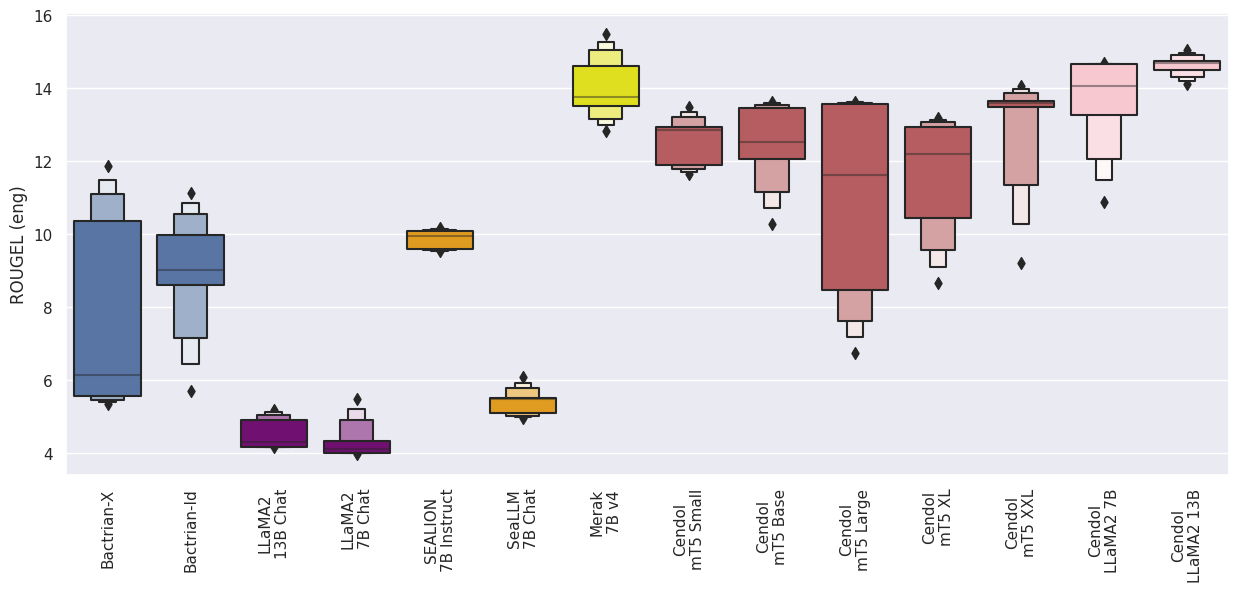

In [384]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
pdf['model_name'] = pdf['model'].apply(lambda x: model_to_display_name[x])
pdf = pdf[pdf['dataset'] == 'xl_sum_nusantara_t2t']
pdf = pdf[(~pdf['model'].str.contains('chat')) | (~pdf['model'].str.contains('cendol'))]
pdf = pdf[(~pdf['model'].str.startswith('bloomz-')) & (~pdf['model'].str.startswith('mt0'))]
pdf = pdf[pdf['lang'] == 'eng'].sort_values('model_id')

ax = sns.boxenplot(pdf, x='model_name', y='ROUGEL', hue='model', k_depth=3, dodge=False, palette=list(model_to_color.values())[10:])
# sns.boxplot(pdf[(pdf['dataset'] == 'xl_sum_nusantara_t2t') & (pdf['lang'] == 'ind')].sort_values('model_id'), x='model', y='ROUGEL', hue='model', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'ind'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
ax.get_legend().set_visible(False)
plt.xticks(rotation=90)
plt.ylabel('ROUGEL (eng)')
plt.xlabel(None)
plt.savefig('./figures/rougel_xlsum_eng.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df.dataset.unique()

array(['flores200-sun_Latn-ind_Latn', 'flores200-jav_Latn-ind_Latn',
       'flores200-bug_Latn-ind_Latn', 'flores200-ace_Latn-ind_Latn',
       'flores200-bjn_Latn-ind_Latn', 'flores200-ban_Latn-ind_Latn',
       'flores200-min_Latn-ind_Latn', 'flores200-ind_Latn-sun_Latn',
       'flores200-ind_Latn-jav_Latn', 'flores200-ind_Latn-bug_Latn',
       'flores200-ind_Latn-ace_Latn', 'flores200-ind_Latn-bjn_Latn',
       'flores200-ind_Latn-ban_Latn', 'flores200-ind_Latn-min_Latn',
       'stif_indonesia_nusantara_t2t', 'tydiqa_id_nusantara_qa',
       'xl_sum_nusantara_t2t', 'korpus_nusantara_ind_jav_nusantara_t2t',
       'korpus_nusantara_ind_xdy_nusantara_t2t',
       'korpus_nusantara_ind_bug_nusantara_t2t',
       'korpus_nusantara_ind_sun_nusantara_t2t',
       'korpus_nusantara_ind_mad_nusantara_t2t',
       'korpus_nusantara_ind_bjn_nusantara_t2t',
       'korpus_nusantara_ind_tiociu_nusantara_t2t',
       'korpus_nusantara_jav_ind_nusantara_t2t',
       'korpus_nusantara_xdy_ind_

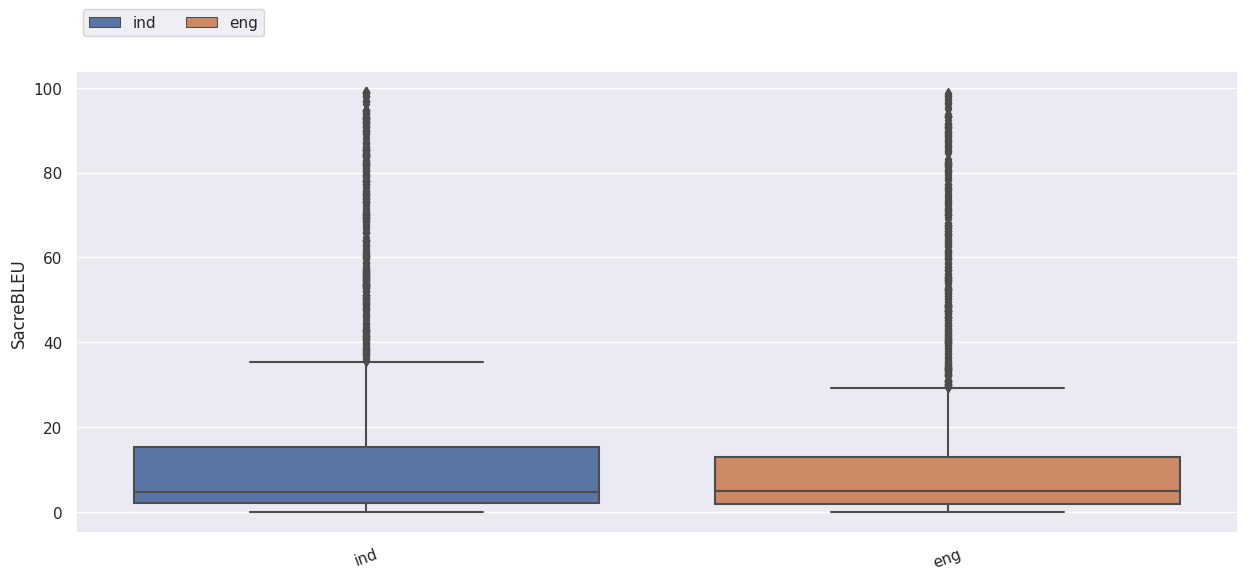

In [93]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxplot(pdf.sort_values('model_id'), x='lang', y='SacreBLEU', hue='lang', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('SacreBLEU')
plt.xlabel(None)
plt.savefig('./figures/sacrebleu_lang.pdf', bbox_inches='tight')
plt.show()

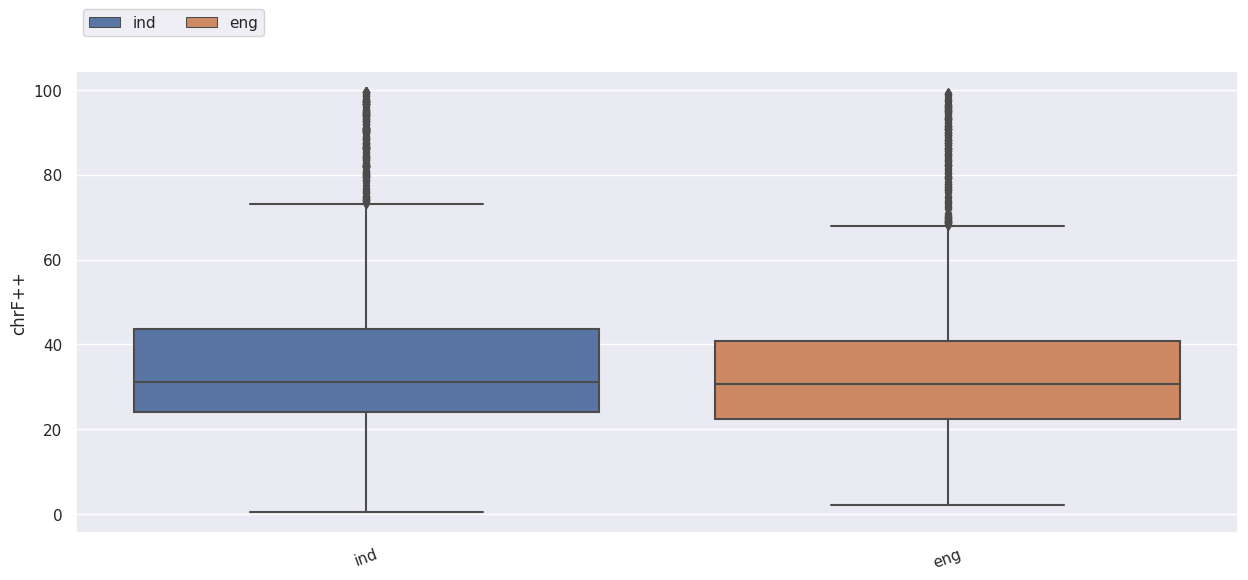

In [94]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxplot(pdf.sort_values('model_id'), x='lang', y='chrF++', hue='lang', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('chrF++')
plt.xlabel(None)
plt.savefig('./figures/chrf_lang.pdf', bbox_inches='tight')
plt.show()

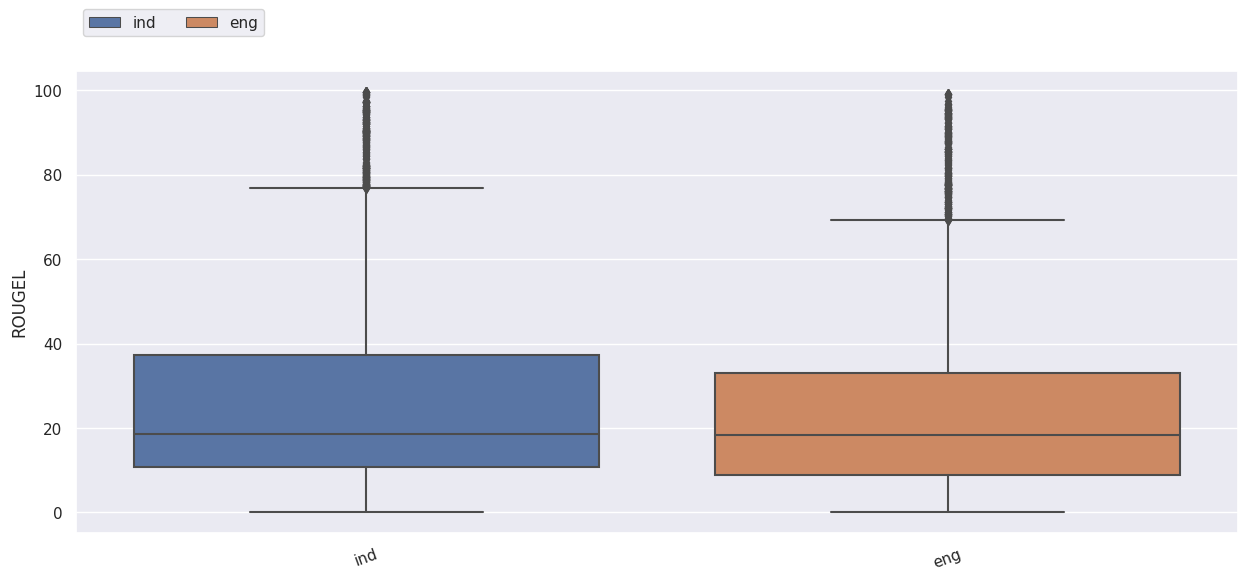

In [95]:
sns.set(rc={'figure.figsize':(15,6)})

pdf = df.copy()
pdf['model_id'] = pdf['model'].apply(lambda x: model_to_index[x])
sns.boxplot(pdf.sort_values('model_id'), x='lang', y='ROUGEL', hue='lang', dodge=False)
# sns.stripplot(pdf[pdf['lang'] == 'eng'].sort_values('model_id'), x='model', y='weighted_f1_score', hue='model', legend=False, alpha=.8)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncols=6)
plt.xticks(rotation=20)
plt.ylabel('ROUGEL')
plt.xlabel(None)
plt.savefig('./figures/rougel_lang.pdf', bbox_inches='tight')
plt.show()

# TEMP

In [3]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap

def make_cmap( colors ): 
    cmap = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in colors ] )
    return cmap

custom_cmap = make_cmap( ['#05a37e','#000000' ] ) 

/tmp/ipykernel_2865/1731637878.py:9: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7f6407b6c820> starts with '_'. It is thus excluded from the legend.
  plt.legend(['_nolegend_', 'ChatGPT', 'GPT-4'], loc='upper right', fontsize=24, fancybox=True, framealpha=0.95)


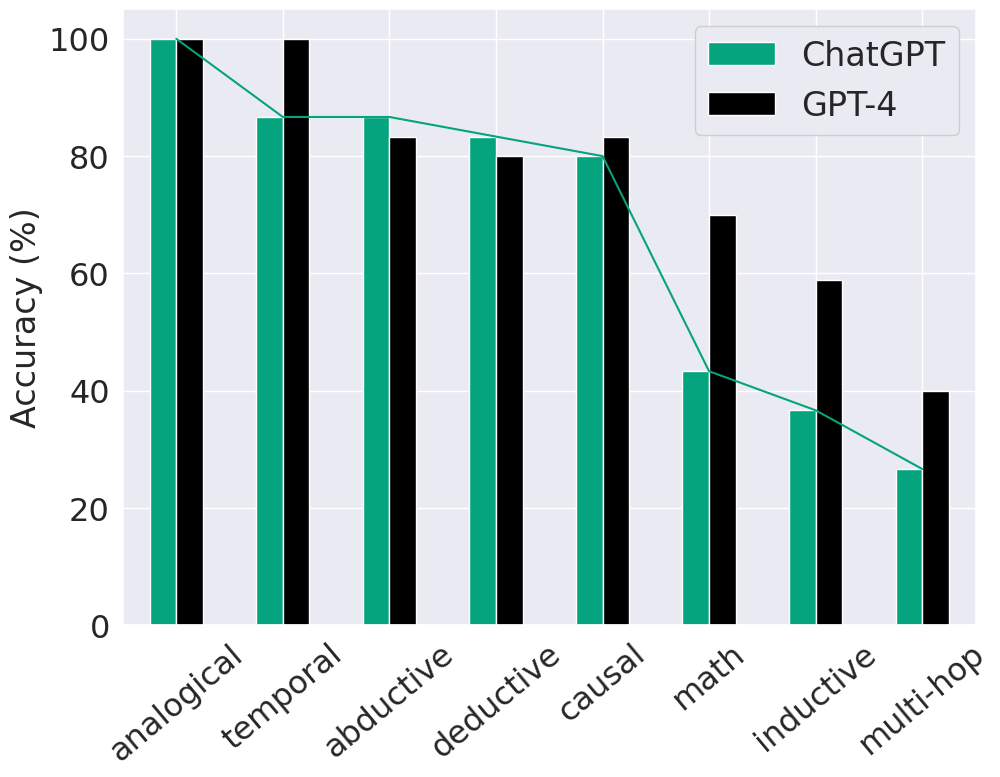

In [20]:
sns.set(rc={'figure.figsize':(11,8)})
df = pd.read_csv('chatgpt.csv').dropna()
df['Reasoning Type'] = df['Reasoning Type'].apply(lambda x: x.replace(' ', '\n'))
ddf = (df.groupby('Reasoning Type')[['ChatGPT', 'GPT-4']].mean() * 100).sort_values(['ChatGPT', 'GPT-4'], ascending=False)

ax = ddf.plot(kind='bar', cmap=custom_cmap)
ddf[['ChatGPT']].plot(ax=ax, cmap=custom_cmap, legend=False)

plt.legend(['_nolegend_', 'ChatGPT', 'GPT-4'], loc='upper right', fontsize=24, fancybox=True, framealpha=0.95)
# plt.legend([ 'ChatGPT', 'GPT-4'], loc='upper left', fontsize=24, fancybox=True, framealpha=0.95)

plt.ylabel('Accuracy (%)', fontsize=24)
plt.xlabel('', fontsize=1)
plt.xticks(fontsize=23, rotation=40)
plt.yticks(fontsize=23)
plt.ylim(0,105)
plt.savefig('reasoning_results.png', bbox_inches='tight')

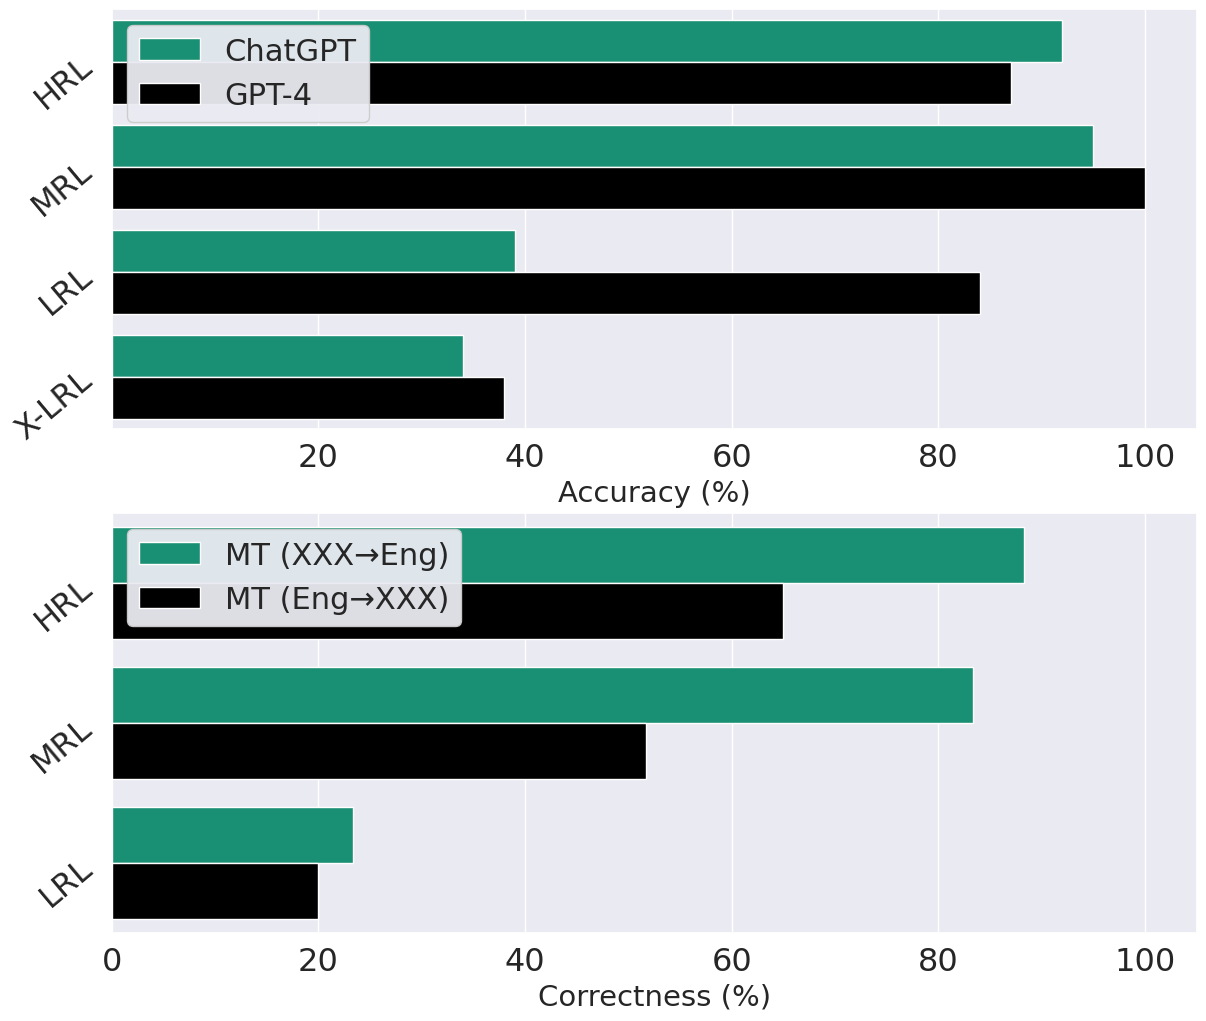

In [77]:
sns.set(rc={'figure.figsize':(14,12)})
df = pd.read_csv('chatgpt-multi.csv').dropna()
df['Accuracy'] = df['Accuracy'] * 100

custom_palette = sns.color_palette(['#05a37e','#000000'])
fig, (ax1, ax2) = plt.subplots(2, 1)

sns.barplot(df[df['Task'].isin(['Sentiment', 'LID'])].sort_values('Model'), y='Resource', x='Accuracy', hue='Model', ax=ax1, palette=custom_palette, errorbar=None)
ax1.set_xlabel('Accuracy (%)', fontsize=21)
ax1.set_ylabel('', fontsize=1)
ax1.set_yticks([0, 1, 2, 3], ['HRL', 'MRL', 'LRL', 'X-LRL'], fontsize=23, rotation=40)
ax1.set_xticks([20, 40, 60, 80, 100], [20, 40, 60, 80, 100], fontsize=23)

h, l = ax1.get_legend_handles_labels()
ax1.legend(handles=h, labels=l, loc='upper left', fontsize=22, framealpha=0.95)

sns.barplot(df[~df['Task'].isin(['Sentiment', 'LID'])].sort_values('Model'), y='Resource', x='Accuracy', hue='Task', ax=ax2, palette=custom_palette)
plt.xlabel('Correctness (%)', fontsize=21)
plt.ylabel('', fontsize=1)
plt.yticks(fontsize=23, rotation=40)
plt.xticks(fontsize=23)

h, l = ax2.get_legend_handles_labels()
ax2.legend(handles=h, labels=l, loc='upper left', fontsize=22, framealpha=0.95)

ax1.set_xlim(0,105)
ax2.set_xlim(0,105)

# plt.ylim(0,105)
plt.savefig('multilingual_results.png', bbox_inches='tight')

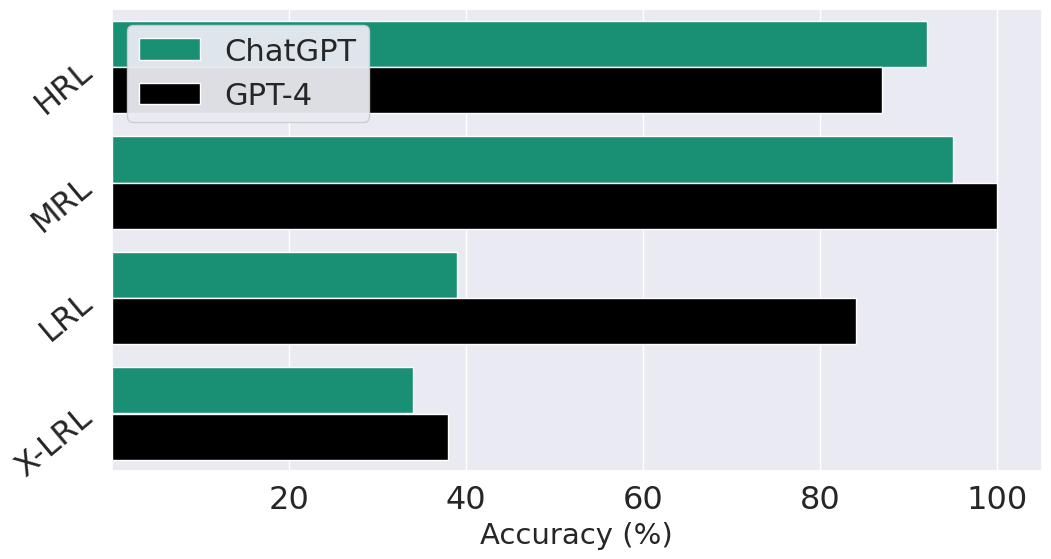

In [85]:
sns.set(rc={'figure.figsize':(12,6)})
df = pd.read_csv('chatgpt-multi.csv').dropna()
df['Accuracy'] = df['Accuracy'] * 100

custom_palette = sns.color_palette(['#05a37e','#000000'])

ax = sns.barplot(df[df['Task'].isin(['Sentiment', 'LID'])].sort_values('Model'), y='Resource', x='Accuracy', hue='Model', palette=custom_palette, errorbar=None)
ax.set_xlabel('Accuracy (%)', fontsize=21)
ax.set_ylabel('', fontsize=1)
ax.set_yticks([0, 1, 2, 3], ['HRL', 'MRL', 'LRL', 'X-LRL'], fontsize=23, rotation=40)
ax.set_xticks([20, 40, 60, 80, 100], [20, 40, 60, 80, 100], fontsize=23)

h, l = ax.get_legend_handles_labels()
ax.legend(handles=h, labels=l, loc='upper left', fontsize=22, framealpha=0.95)

# sns.barplot(df[~df['Task'].isin(['Sentiment', 'LID'])].sort_values('Model'), y='Resource', x='Accuracy', hue='Task', ax=ax2, palette=custom_palette)
# plt.xlabel('Correctness (%)', fontsize=21)
# plt.ylabel('', fontsize=1)
# plt.yticks(fontsize=23, rotation=40)
# plt.xticks(fontsize=23)

# h, l = ax2.get_legend_handles_labels()
# ax2.legend(handles=h, labels=l, loc='upper left', fontsize=22, framealpha=0.95)

# ax1.set_xlim(0,105)
# ax2.set_xlim(0,105)

# plt.ylim(0,105)
plt.savefig('multilingual_results.png', bbox_inches='tight')